<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE6.2-Decision_AGENT_EVALUATION_BATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train: (444587, 100, 12)
Test : (280283, 100, 12)
Hold : (346681, 100, 12)
✅ Found pretrained Transformer. Loading...
{'p_normal': 0.5116674900054932, 'early_fault_score': 0.43738940358161926, 'severe_fault_score': 0.05094306915998459, 'anomaly_score': 0.48833250999450684}
✅ Loaded PRECOMP: 31000 samples | evaluating: 5000
🆕 Starting fresh precomp-based holdout evaluation
💾 Saved checkpoint at 2000/5000 | elapsed=0.2 min
💾 Saved checkpoint at 4000/5000 | elapsed=0.4 min

================ HOLDOUT RESULTS =================

🟦 TRANSFORMER — WARNING
Recall   : 0.940771349862259
Precision: 0.8298906439854192
F1       : 0.881859264041317

🟩 DECISION AGENT — WARNING
Recall   : 0.9173553719008265
Precision: 0.8683181225554107
F1       : 0.8921634293369055

🟥 TRANSFORMER — FAILURE
Recall   : 0.8832074375363161
Precision: 1.0
F1       : 0.9379821042887998

🟧 DECISION AGENT — FAILURE
Recall   : 0.8762347472399767
Precision: 1.0
F1       : 0.9340353050480025
✅ Bucket analysis saved to bucket_analy

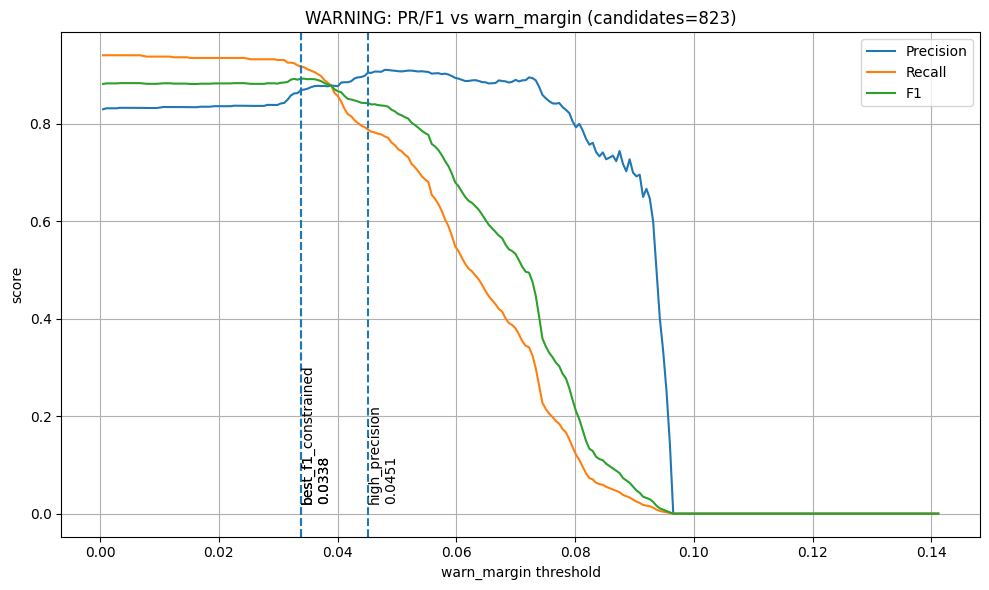

In [33]:

# ============================================================
# Fault Classification Pipeline
# ============================================================

############PASTE ADAPTIVE WINDOW HERE - so everything is in one file - later, we can import as a package#####################


# ====== AdaptiveWindowAgent ======
# =====================================================
# AdaptiveWindowAgent (improved version)
# =====================================================
# agents/adaptive_window_agent.py
import numpy as np
import pandas as pd
import pickle
import json
import os
from collections import deque
from typing import Dict, Any
import datetime as dt
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  # ✅ MOVED TO TOP
from statsmodels.tsa.vector_ar.var_model import VAR
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

logger = logging.getLogger(__name__)

import sqlite3
import json
from datetime import datetime
import json


class EventStore:
    def __init__(self, db_path="event_store.db"):
        self.conn = sqlite3.connect(db_path)
        self._init_tables()

    def _init_tables(self):
        c = self.conn.cursor()
        c.execute("""
            CREATE TABLE IF NOT EXISTS events (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp TEXT,
                event_type TEXT,
                packet_json TEXT,
                expert_json TEXT,
                human_json TEXT
            )
        """)
        self.conn.commit()

    def save_event(self, event_type, packet, expert=None, human=None):
        c = self.conn.cursor()
        c.execute(
            "INSERT INTO events(timestamp,event_type,packet_json,expert_json,human_json) VALUES (?,?,?,?,?)",
            (
                datetime.now().isoformat(),
                event_type,
                json.dumps(packet, default=str),
                json.dumps(expert, default=str) if expert else None,
                json.dumps(human, default=str) if human else None,
            )
        )
        self.conn.commit()

    def fetch_recent(self, limit=100):
        c = self.conn.cursor()
        c.execute("SELECT packet_json, expert_json, human_json FROM events ORDER BY id DESC LIMIT ?", (limit,))
        return [json.loads(row[0]) for row in c.fetchall()]

######################################################################################
# DECISION POLICY CONFIGS-----------------------------------------------------------
######################################################################################'

# =====================================================
# DECISION POLICY (SEPARATED FROM LOGIC)
# =====================================================

BASE_POLICY = {
    # --- detection fusion ---
    "w_sensor": 0.20,
    "w_window": 0.80,

    # --- drift fusion ---
    "w_fdi": 0.50,
    "w_wdi": 0.25,
    "w_sensor_drift": 0.25,

    # --- failure prediction ---
    "w_fault": 0.70,
    "w_warn": 0.15,
    "w_det_context": 0.15,

    # --- thresholds ---
    "detection_threshold": 0.50,
    "drift_threshold": 0.35,
    "failure_threshold": 0.50,
    "failure_critical_threshold": 0.80,

    # --- alert mapping ---
    "alert_low": 0.35,
    "alert_med": 0.55,
    "alert_high": 0.75,
}


#########################################################################
# Window Agent - Global Context or Global Predictive Context
#########################################################################

class AdaptiveWindowAgent:
    """
    Adaptive Window Agent:
    - Predicts window size using MLP
    - Evaluates forecast with RF/persistence
    - Computes:
        * FDS: Forecast Deviation Score (normalized error)
        * FDI: Forecast Drift Index (JSD over FDS distribution)
        * WSS: Window Shift Score (normalized window size)
        * WDI: Window Drift Index (JSD over window size distribution)
    - Detects anomaly (local) + drift (regime) events.
    """

    def __init__(self, agent_id="adaptive_window_agent",
                 model_path=None, checkpoint_path=None):
        self.agent_id = agent_id
        self.model_path = model_path or "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_10Sec.keras"

        self.baseline_path = "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_baseline.pkl"
        self.checkpoint_path = checkpoint_path

        # --------------------------------------------------
        # Core model
        # --------------------------------------------------
        self.model = None
        self.transformer = StandardScaler()
        self.transformer_fitted = False
        self.is_model_loaded = False

        # Baseline error stats (median / MAD) – filled from baseline file
        self.rolling_stats = {
            'median': 0.0,
            'mad': 1.0,
        }

        # --------------------------------------------------
        # Metrics memory
        # --------------------------------------------------
        # Raw error
        self.error_memory = deque(maxlen=300)     # long-term errors
        self.recent_errors = deque(maxlen=50)     # kept for backward compat (not central now)

        # FDS (Forecast Deviation Score) history
        self.fds_memory = deque(maxlen=300)
        self.recent_fds = deque(maxlen=50)

        # Window history
        self.window_memory = deque(maxlen=300)
        self.recent_windows = deque(maxlen=50)

        # Last-step metrics (for returning)
        self.last_fds = 0.0
        self.last_fdi = 0.0
        self.last_wss = 0.0
        self.last_wdi = 0.0

        # Baseline distributions
        self.baseline_errors = None
        self.baseline_fds = None
        self.baseline_windows = None
        self.window_mean = 50.0    # a reasonable mid value
        self.window_std = 10.0     # non-zero, avoids div-by-zero

        # Optional histogram bins stored in baseline
        self.window_hist_bins = None
        self.window_hist_counts = None

        # Debug flag (OFF by default)
        self.debug = False

        # --------------------------------------------------
        # Anomaly / drift settings
        # --------------------------------------------------
        self.threshold_k = 3.0
        self.anomaly_cooldown = 0
        self.anomaly_cooldown_steps = 5

        # Drift detection
        self.drift_threshold = 0.25          # for FDI (JSD over FDS)
        self.window_drift_threshold = 0.20   # for WDI (JSD over window sizes)
        self.consecutive_drift_votes = 0
        self.drift_cooldown = 0
        self.drift_votes_required = 10
        self.drift_cooldown_steps = 100

        # --------------------------------------------------
        # Retraining buffer (unchanged)
        # --------------------------------------------------
        self.performance_stats = {
            'total_predictions': 0,
            'avg_mse': 0.0,
            'avg_mae': 0.0,
            'last_retrain_time': None,
            'drift_events': 0,
            'anomaly_events': 0,
            'retraining_events': 0
        }

        self.retraining_data = {
            'x_buffer': deque(maxlen=10000),
            'y_buffer': deque(maxlen=10000)
        }

        # --------------------------------------------------
        # Prediction history (for reporting)
        # --------------------------------------------------
        self.prediction_history = deque(maxlen=1000)
        self.mse_history = deque(maxlen=200)
        self.mae_history = deque(maxlen=200)

        # --------------------------------------------------
        # Load baseline (errors + windows)
        # --------------------------------------------------
        self._load_baseline()

        # --------------------------------------------------
        # Load model last
        # --------------------------------------------------
        self.load_model()
        print(f"AdaptiveWindowAgent {self.agent_id} initialized")

        # --------------------------------------------------
        # Load NSP (Next-Step Predictor)
        # --------------------------------------------------
        self.nsp_model_path = "/content/drive/MyDrive/PHD/2025/NSP_LSTM_next_step.keras"
        self.nsp_model = keras.models.load_model(self.nsp_model_path)
        print("✅ Loaded NSP LSTM next-step predictor")

    # =================== BASELINE LOADING ===================

    def _load_baseline(self):
        """
        Load baseline stats:
          - baseline_errors, median, mad
          - baseline_windows, window_mean, window_std
          - optional histogram bins/counts for windows
        """
        if os.path.exists(self.baseline_path):
            with open(self.baseline_path, "rb") as f:
                base = pickle.load(f)

            # Error baseline
            self.baseline_errors = np.array(base["baseline_errors"])
            self.rolling_stats["median"] = base["median"]
            self.rolling_stats["mad"] = base["mad"]

            # Precompute baseline FDS distribution
            med = self.rolling_stats["median"]
            mad = self.rolling_stats["mad"] if self.rolling_stats["mad"] > 0 else 1e-6
            self.baseline_fds = (self.baseline_errors - med) / (mad + 1e-8)

            # Window baseline (may or may not exist)
            if "baseline_windows" in base:
                self.baseline_windows = np.array(base["baseline_windows"])
                self.window_mean = float(base.get("window_mean", np.mean(self.baseline_windows)))
                self.window_std = float(base.get("window_std", np.std(self.baseline_windows) + 1e-8))
                self.window_hist_bins = np.array(base.get("window_hist_bins", [])) if "window_hist_bins" in base else None
                self.window_hist_counts = np.array(base.get("window_hist_counts", [])) if "window_hist_counts" in base else None
            else:
                self.baseline_windows = None
                self.window_mean = 0.0
                self.window_std = 1.0
                self.window_hist_bins = None
                self.window_hist_counts = None

            print("✅ Loaded baseline error + window distribution.")
            print(f"   Error median={self.rolling_stats['median']:.6f}, MAD={self.rolling_stats['mad']:.6f}")
            if self.baseline_windows is not None:
                print(f"   Window mean={self.window_mean:.3f}, std={self.window_std:.3f}")
        else:
            print("⚠️ No baseline found. Using live history only.")
            self.baseline_errors = None
            self.baseline_fds = None
            self.baseline_windows = None

    # =================== MODEL LOADING ===================

    def load_model(self):
        try:
            if os.path.exists(self.model_path):
                self.model = keras.models.load_model(self.model_path)
                self.is_model_loaded = True
                print(f"✅ Loaded MLP model from {self.model_path}")

                # Try to load transformer
                transformer_path = self.model_path.replace('.keras', '_transformer.pkl')
                if os.path.exists(transformer_path):
                    with open(transformer_path, 'rb') as f:
                        self.transformer = pickle.load(f)
                    self.transformer_fitted = True
                else:
                    # Fit transformer from true window labels
                    y_original = np.load(
                        "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data-true-window2.npy"
                    )
                    self.transformer.fit(y_original.reshape(-1, 1))
                    self.transformer_fitted = True
                    with open(transformer_path, 'wb') as f:
                        pickle.dump(self.transformer, f)
                    print("⚠️ No transformer found, fitted a new one.")
            else:
                print(f"❌ Model not found at {self.model_path}")
        except Exception as e:
            print(f"❌ Error loading model: {e}")

    # =================== FORECAST EVALUATION ===================

    def evaluate_forecast_performance(self, sequence_3d, predicted_window, n_future=1):
        try:
            seq = np.asarray(sequence_3d)
            T, F = seq.shape

            W = int(predicted_window)
            if W < 2:
                W = 2
            if W > T - n_future - 1:
                W = max(2, T - n_future - 1)

            # --- Prepare NSP input ---
            window = seq[-W:-n_future, :]   # shape (W-1, F)
            x = window[np.newaxis, ...]      # shape (1, W-1, F)

            # --- NSP prediction ---
            y_pred = self.nsp_model.predict(x, verbose=0)[0]  # (F,)
            y_true = seq[-n_future, :]                        # (F,)

            mse = float(np.mean((y_true - y_pred) ** 2))
            mae = float(np.mean(np.abs(y_true - y_pred)))

            return {
                "mse": mse,
                "mae": mae,
                "forecast_success": True,
                "actual_values": y_true.tolist(),
                "predicted_values": y_pred.tolist(),
                "window_size_used": W,
                "method": "NSP_LSTM"
            }

        except Exception as e:
            return {
                "mse": 9999.0,
                "mae": 9999.0,
                "forecast_success": False,
                "error": str(e),
                "method": "NSP_LSTM"
            }

    # =================== PERSISTENCE FALLBACK ===================

    def _persistence_forecast(self, seq, target_sensor_index, n_future):
        """
        Persistence fallback for RF evaluation.
        Last-value-carried-forward for target sensor.
        """
        try:
            seq = np.asarray(seq)
            if len(seq) < 2:
                return {
                    'mse': 9999,
                    'mae': 9999,
                    'forecast_success': False,
                    'error': 'Sequence too short',
                    'method': 'Persistence'
                }

            last_value = seq[-1, target_sensor_index]
            predicted_vals = [last_value]
            actual = [seq[-1, target_sensor_index]]

            mse = 0.0
            mae = 0.0

            return {
                'mse': mse,
                'mae': mae,
                'forecast_success': True,
                'actual_values': actual,
                'predicted_values': predicted_vals,
                'target_sensor_index': target_sensor_index,
                'method': 'Persistence',
                'note': 'persistence_fallback'
            }

        except Exception as e:
            return {
                'mse': 9999,
                'mae': 9999,
                'forecast_success': False,
                'error': str(e),
                'method': 'Persistence',
                'note': 'persistence_fallback_failed'
            }

    # =================== PREDICTION PIPELINE ===================

    def predict_window_size(self, feature_vector, sequence_3d):
        """
        Main entrypoint:
          - Predict window W_t
          - Evaluate forecast error e_t
          - Compute FDS (S_t) and WSS (Z_t)
          - Update drift/anomaly logic (FDI, WDI, events)
          - Return full metrics packet
        """
        if not self.is_model_loaded:
            return {'predicted_window': 20, 'error': "Model not loaded"}

        try:
            if feature_vector.ndim == 1:
                feature_vector = feature_vector.reshape(1, -1)

            pred_raw = self.model.predict(feature_vector, verbose=0)

            if self.transformer_fitted:
                predicted_window = int(round(self.transformer.inverse_transform(pred_raw)[0, 0]))
            else:
                predicted_window = int(round(pred_raw[0, 0]))

            # ----------------------------------------
            # WINDOW CLAMP — HARD SAFETY FIX
            # ----------------------------------------
            # Prevent negative, zero, or extreme window sizes
            predicted_window = max(2, predicted_window)        # lower bound

            # Forecast evaluation
            forecast_metrics = self.evaluate_forecast_performance(sequence_3d, predicted_window, n_future=1)

            fds = None
            wss = None

            if forecast_metrics.get("forecast_success", False):
                mse = forecast_metrics["mse"]
                mae = forecast_metrics["mae"]

                # Basic stats
                self.mse_history.append(mse)
                self.mae_history.append(mae)
                self.error_memory.append(mse)

                self.performance_stats['total_predictions'] += 1
                self.performance_stats['avg_mse'] = float(np.mean(self.mse_history))
                self.performance_stats['avg_mae'] = float(np.mean(self.mae_history))

                # ---------- Forecast Deviation Score (FDS) ----------
                baseline_median = self.rolling_stats["median"]
                baseline_mad = self.rolling_stats["mad"] if self.rolling_stats["mad"] > 0 else 1e-6
                fds = (mse - baseline_median) / (baseline_mad + 1e-8)
                fds = float(fds) if fds is not None and not np.isnan(fds) else 0.0


                self.last_fds = fds
                self.fds_memory.append(fds)
                self.recent_fds.append(fds)

                # ---------- Window Shift Score (WSS) ----------
                if self.baseline_windows is not None and self.window_std > 0:
                    wss = (predicted_window - self.window_mean) / (self.window_std + 1e-8)
                else:
                    wss = 0.0

                wss = float(wss)
                self.last_wss = wss
                self.window_memory.append(predicted_window)
                self.recent_windows.append(predicted_window)

            # Event (ANOMALY / DRIFT) + Drift indices
            event, sev, fdi, wdi = self._check_for_event()
            self.last_fdi = fdi
            self.last_wdi = wdi

            # Save history for reporting
            record = {
                'timestamp': dt.datetime.now(),
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'fds': self.last_fds,
                'wss': self.last_wss,
                'fdi': self.last_fdi,
                'wdi': self.last_wdi,
                'event_type': event,
                'severity': sev
            }
            self.prediction_history.append(record)

            return {
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'fds': self.last_fds,
                'fdi': self.last_fdi,
                'wss': self.last_wss,
                'wdi': self.last_wdi,
                'event_type': event,
                'severity': sev,
                'performance_stats': self.get_recent_performance()
            }
        except Exception as e:
            return {'predicted_window': 20, 'error': str(e)}

    # =================== EVENT LOGIC (ANOMALY + DRIFT) ===================

    def _check_for_event(self):
        """
        Event detection for the Adaptive Window Agent.

        - ANOMALY: deviation of last MSE from baseline (median + k * MAD)
        - DRIFT:
            * FDI: JSD between recent FDS distribution and baseline FDS
            * WDI: JSD between recent window distribution and baseline window distribution
        """
        # Require enough history
        if len(self.error_memory) < 30:
            return None, 0.0, None, None

        last_mse = float(self.error_memory[-1])
        live_errors = np.array(self.error_memory)

        # ---------- BASELINE STATS ----------
        if self.baseline_errors is not None and len(self.baseline_errors) > 10:
            base_errors = np.array(self.baseline_errors)
            baseline_median = np.median(base_errors)
            baseline_mad = np.median(np.abs(base_errors - baseline_median)) + 1e-8
        else:
            baseline_median = np.median(live_errors)
            baseline_mad = np.median(np.abs(live_errors - baseline_median)) + 1e-8

        # Update rolling_stats so other components can see latest baseline-ish values
        self.rolling_stats["median"] = baseline_median
        self.rolling_stats["mad"] = baseline_mad

        # ---------- LIVE STATS ----------
        live_median = np.median(live_errors)
        live_mad = np.median(np.abs(live_errors - live_median)) + 1e-8

        # ---------- ANOMALY THRESHOLD ----------
        baseline_threshold = baseline_median + self.threshold_k * baseline_mad
        live_threshold = live_median + self.threshold_k * live_mad

        anomaly_threshold = 0.8 * baseline_threshold + 0.2 * live_threshold

        is_anomaly = last_mse > anomaly_threshold

        if self.anomaly_cooldown > 0:
            self.anomaly_cooldown -= 1
            is_anomaly = False
        elif is_anomaly:
            self.anomaly_cooldown = self.anomaly_cooldown_steps

        if is_anomaly:
            severity = (last_mse - anomaly_threshold) / (baseline_mad + 1e-6)
            severity = float(severity)
            self.performance_stats["anomaly_events"] += 1
            if self.debug:
                print(f"[ANOMALY] mse={last_mse:.6f}, thr={anomaly_threshold:.6f}, sev={severity:.3f}")
            return "ANOMALY", severity, 0.0, 0.0

        # ---------- DRIFT (FDI + WDI) ----------
        fdi = None
        wdi = None

        # FDI: JSD over FDS distribution
        if self.baseline_fds is not None and len(self.recent_fds) >= 30:
            base_fds = np.asarray(self.baseline_fds)
            recent_fds = np.asarray(self.recent_fds)

            hist_base, bins = np.histogram(base_fds, bins=25, density=True)
            hist_recent, _ = np.histogram(recent_fds, bins=bins, density=True)

            hist_base = hist_base / (hist_base.sum() + 1e-12)
            hist_recent = hist_recent / (hist_recent.sum() + 1e-12)

            fdi = float(jensenshannon(hist_base + 1e-12, hist_recent + 1e-12))

        # WDI: JSD over window-size distribution
        if self.baseline_windows is not None and len(self.recent_windows) >= 30:
            base_win = np.asarray(self.baseline_windows)
            recent_win = np.asarray(self.recent_windows)

            hist_w_base, bins_w = np.histogram(base_win, bins=20, density=True)
            hist_w_recent, _ = np.histogram(recent_win, bins=bins_w, density=True)

            hist_w_base = hist_w_base / (hist_w_base.sum() + 1e-12)
            hist_w_recent = hist_w_recent / (hist_w_recent.sum() + 1e-12)

            wdi = float(jensenshannon(hist_w_base + 1e-12, hist_w_recent + 1e-12))

        # Decide drift if either index is high
        is_drift_fdi = fdi is not None and fdi > self.drift_threshold
        is_drift_wdi = wdi is not None and wdi > self.window_drift_threshold

        #is_drift = is_drift_fdi or is_drift_wdi
        is_drift = is_drift_wdi #just focus on window drift
        if self.drift_cooldown > 0:
            self.drift_cooldown -= 1
            is_drift = False
        else:
            if is_drift:
                self.consecutive_drift_votes += 1
            else:
                self.consecutive_drift_votes = 0

        if self.consecutive_drift_votes >= self.drift_votes_required:
            self.consecutive_drift_votes = 0
            self.drift_cooldown = self.drift_cooldown_steps
            self.performance_stats["drift_events"] += 1
            if self.debug:
                print(f"[DRIFT] FDI={fdi:.4f} WDI={wdi:.4f}")
            fdi = float(fdi) if fdi is not None else 0.0
            wdi = float(wdi) if wdi is not None else 0.0
            return "DRIFT", fdi, fdi, wdi

        # Make safe for printing
        fdi = float(fdi) if fdi is not None else 0.0
        wdi = float(wdi) if wdi is not None else 0.0

        return None, 0.0, fdi, wdi


    # =================== HELPERS ===================

    def get_recent_performance(self):
        all_preds = list(self.prediction_history)

        successful_predictions = [
            p for p in all_preds
            if p.get('forecast_metrics', {}).get('forecast_success', False)
        ]

        return {
            'total_predictions': len(all_preds),
            'successful_predictions': len(successful_predictions),
            'success_rate': len(successful_predictions) / max(len(all_preds), 1),
            'drift_events': self.performance_stats['drift_events'],
            'anomaly_events': self.performance_stats['anomaly_events'],
            'retraining_events': self.performance_stats['retraining_events'],
            'recent_mse': float(np.mean(list(self.mse_history)[-10:])) if self.mse_history else 0,
            'avg_mse': float(np.mean(self.mse_history)) if self.mse_history else 0,
            'recent_mae': float(np.mean(list(self.mae_history)[-10:])) if self.mae_history else 0,
            'avg_mae': float(np.mean(self.mae_history)) if self.mae_history else 0,
            'transformer_fitted': self.transformer_fitted,
            'last_fdi': self.last_fdi,
            'last_wdi': self.last_wdi,
        }

    def save_performance_state(self, filepath: str):
        """Save performance statistics + prediction history to JSON"""
        try:
            state = {
                'performance_stats': self.performance_stats.copy(),
                'prediction_history': list(self.prediction_history)[-100:],
                'mse_history': list(self.mse_history),
                'mae_history': list(self.mae_history),
                'transformer_fitted': self.transformer_fitted
            }
            with open(filepath, 'w') as f:
                json.dump(state, f, indent=2, default=str)
            print(f"✅ Performance state saved to {filepath}")
        except Exception as e:
            print(f"❌ Failed to save performance state: {e}")


#===============================================================================================================================================
###  SENSOR AGENTS - INDIVIDUAL AND MASTER
#--------------------------------------==========================================================================================================
import numpy as np
import pickle
import os
from collections import deque
from datetime import datetime
from typing import Dict, List, Tuple
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.spatial.distance import jensenshannon

# Deep learning
try:
    from tensorflow.keras.models import load_model
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)


# =====================================================
# ROBUST SENSOR AGENT - Observes ONE sensor with AE model
# =====================================================


# =====================================================
# ROBUST SENSOR AGENT - Observes ONE sensor with AE model
# =====================================================

class RobustSensorAgent:
    """
    Robust Sensor Agent for ONE sensor with advanced anomaly & drift detection.

    Loads pretrained AE model + metadata (scaler, baseline errors, rolling stats).
    Computes anomaly score via reconstruction error, applies adaptive thresholding,
    drift detection, and outputs robust anomaly/drift/retrain flags.
    """

    def __init__(self,
                 sensor_id: int,
                 model_path: str = None,
                 window_length: int = 10, #K
                 memory_size: int = 1000,
                 threshold_k: float = 2.0,
                 drift_threshold: float = 0.1,
                warmup_steps: int = 100):    # <── NEW PARAM

        self.sensor_id = sensor_id
        self.window_length = window_length
        self.threshold_k = threshold_k
        self.drift_threshold = drift_threshold
        self.warmup_steps = warmup_steps

        # Model & metadata
        self.model = None
        self.scaler = None
        self.is_model_loaded = False

        # Buffers
        self.error_memory = deque(maxlen=memory_size)
        self.data_memory = deque(maxlen=memory_size)
        self.recent_errors = deque(maxlen=100)

        # Rolling stats
        self.rolling_stats = {
            'median': 0.0,
            'mad': 1.0,
            'mean': 0.0,   # backward compatibility
            'std': 1.0,    # backward compatibility
            'q95': 0.0,
            'q99': 0.0
        }
        self.baseline_errors = None

        # Counters
        self.total_processed = 0
        self.anomalies_detected = 0
        self.drift_detected_count = 0
        self.last_stats_update = datetime.now()

        self.anomaly_cooldown = 0
        self.drift_cooldown = 0

        self.anomaly_cooldown_steps = 5    # you can tune
        self.drift_cooldown_steps = 10     # you can tune

        self.consecutive_drift_votes = 0
        self.consecutive_anomaly_votes = 0

        if model_path:
            self.load_model(model_path)

    def load_model(self, model_path: str) -> bool:
        """Load pretrained AE model + metadata."""
        try:
            if KERAS_AVAILABLE and model_path.endswith('.h5'):
                self.model = load_model(model_path, compile=False)

                # Correct metadata file
                metadata_path = model_path.replace('_model.h5', '_metadata.pkl')

                if os.path.exists(metadata_path):
                    with open(metadata_path, 'rb') as f:
                        metadata = pickle.load(f)

                    baseline = metadata.get('baseline_stats', None)

                    if baseline is not None:
                        # Initialize rolling stats from training
                        # Load robust baseline stats
                        self.rolling_stats['median'] = baseline.get('median')
                        self.rolling_stats['mad']    = baseline.get('mad')

                        # Backward compatibility for other parts of system
                        self.rolling_stats['mean'] = self.rolling_stats['median']
                        self.rolling_stats['std']  = self.rolling_stats['mad']

                        self.rolling_stats['q95']  = baseline['q95']
                        self.rolling_stats['q99']  = baseline['q99']

                        # Save baseline distribution for drift detection
                        self.baseline_errors = np.array(baseline['baseline_errors'])

                # AE was trained on raw, NOT scaled
                self.scaler = None

            else:
                raise ValueError("Unsupported model format – expecting .h5 AE model")

            self.is_model_loaded = True
            print(f"✅ AE model loaded for sensor {self.sensor_id}")
            return True

        except Exception as e:
            print(f"❌ Failed to load AE model for sensor {self.sensor_id}: {e}")
            return False


    def observe(self, sensor_subsequence: np.ndarray) -> Dict:
        """Observe subsequence [window_length] and return anomaly/drift flags."""
        if not self.is_model_loaded:
            return {"sensor_id": self.sensor_id, "error": "no_model_loaded", "timestamp": datetime.now()}

        if len(sensor_subsequence) != self.window_length:
            return {"sensor_id": self.sensor_id,
                    "error": f"invalid_length_expected_{self.window_length}_got_{len(sensor_subsequence)}",
                    "timestamp": datetime.now()}

        # 1. Anomaly score
        anomaly_score = self._compute_robust_anomaly_score(sensor_subsequence)

        # 2. Update memory
        self.data_memory.append(sensor_subsequence.copy())
        self.error_memory.append(anomaly_score)
        self.recent_errors.append(anomaly_score)

        # 3

        # --------------- WARM-UP PHASE -----------------
        # During warm-up, rolling stats ignore live data and stay fixed
        if self.total_processed < self.warmup_steps:
            med = np.median(self.baseline_errors)
            mad = np.median(np.abs(self.baseline_errors - med)) + 1e-8

            self.rolling_stats['median'] = med
            self.rolling_stats['mad'] = mad
            self.rolling_stats['mean'] = med     # backward compatibility
            self.rolling_stats['std'] = mad
        else:
            # After warm-up, rolling stats evolve normally
            if len(self.error_memory) >= 50 and len(self.error_memory) % 10 == 0:
                self._update_rolling_stats(list(self.error_memory)[-50:])

        # 4. Flags
        is_anomaly = self._check_adaptive_anomaly(anomaly_score)
        drift_flag = self._check_advanced_drift()
        needs_retrain = self._check_retrain_need()
        confidence = self._compute_robust_confidence(anomaly_score)

        # 5. Update counters
        self.total_processed += 1
        if is_anomaly: self.anomalies_detected += 1
        if drift_flag: self.drift_detected_count += 1

        return {
            "sensor_id": self.sensor_id,
            "timestamp": datetime.now(),
            "is_anomaly": bool(is_anomaly),
            "drift_flag": bool(drift_flag),
            "needs_retrain_flag": bool(needs_retrain),
            "anomaly_score": float(anomaly_score),
            "confidence": float(confidence),
            "threshold_used": float(self.rolling_stats['median'] + self.threshold_k * self.rolling_stats['mad']),
            "anomaly_rate": self.anomalies_detected / max(1, self.total_processed),
            "drift_rate": self.drift_detected_count / max(1, self.total_processed)
        }

    def _compute_robust_anomaly_score(self, subsequence: np.ndarray) -> float:
        """Compute reconstruction error using AE model on RAW values."""
        try:
            # Ensure shape: [1, window_length, 1]
            X = subsequence.reshape(1, self.window_length, 1)
            reconstruction = self.model.predict(X, verbose=0)

            error = mean_squared_error(
                subsequence.flatten(),
                reconstruction.flatten()
            )
            return max(0.0, error)

        except Exception as e:
            print(f"⚠️ AE inference failed for sensor {self.sensor_id}: {e}")
            # Fallback: variance of raw subsequence
            return float(np.var(subsequence))

    def _update_rolling_stats(self, errors: List[float]):
        errors_array = np.array(errors)

        median = np.median(errors_array)
        mad = np.median(np.abs(errors_array - median)) + 1e-8  # avoid zero

        # Store
        self.rolling_stats['median'] = median
        self.rolling_stats['mad'] = mad

        # Backward compatibility fields (for plotting)
        self.rolling_stats['mean'] = median
        self.rolling_stats['std'] = mad

        # Percentile bands (unchanged; good for drift & visualization)
        self.rolling_stats['q95'] = np.percentile(errors_array, 95)
        self.rolling_stats['q99'] = np.percentile(errors_array, 99)

        self.last_stats_update = datetime.now()

    def _check_adaptive_anomaly(self, score: float) -> bool:
        median = self.rolling_stats.get('median', self.rolling_stats['mean'])
        mad = self.rolling_stats.get('mad', self.rolling_stats['std'])
        threshold = median + self.threshold_k * mad
        is_anomaly_now = score > threshold

        # Cooldown active → suppress anomaly
        if self.anomaly_cooldown > 0:
            self.anomaly_cooldown -= 1
            return False

        # No cooldown and anomaly happened → activate cooldown
        if is_anomaly_now:
            self.anomaly_cooldown = self.anomaly_cooldown_steps
            return True

        return False

    def _check_advanced_drift(self) -> bool:
        if self.baseline_errors is None or len(self.recent_errors) < 30:
            return False
        try:
            hist_baseline, bins = np.histogram(self.baseline_errors, bins=20, density=True)
            hist_recent, _ = np.histogram(list(self.recent_errors), bins=bins, density=True)
            hist_baseline += 1e-10; hist_recent += 1e-10
            hist_baseline /= hist_baseline.sum(); hist_recent /= hist_recent.sum()
            js_divergence = jensenshannon(hist_baseline, hist_recent)
            is_drift_now = js_divergence > self.drift_threshold

            # Cooldown active → suppress
            if self.drift_cooldown > 0:
                self.drift_cooldown -= 1
                return False

            # Multi-step confirmation: require 3 drift votes in last few steps
            if is_drift_now:
                self.consecutive_drift_votes += 1
            else:
                self.consecutive_drift_votes = 0

            if self.consecutive_drift_votes >= 3:
                self.drift_cooldown = self.drift_cooldown_steps
                self.consecutive_drift_votes = 0
                return True

            return False

        except Exception:
            try:
                _, p_value = stats.ks_2samp(self.baseline_errors, list(self.recent_errors))
                return p_value < 0.05
            except:
                return False

    def _check_retrain_need(self) -> bool:
        if len(self.error_memory) < 100: return False
        recent_errors = list(self.error_memory)[-50:]
        threshold = self.rolling_stats['mean'] + self.threshold_k * self.rolling_stats['std']
        anomaly_rate = sum(1 for e in recent_errors if e > threshold) / len(recent_errors)
        criteria = [
            anomaly_rate > 0.3,
            self.drift_detected_count > 0.1 * self.total_processed,
            np.mean(recent_errors) > 2.0 * self.rolling_stats['mean'] if len(recent_errors) > 0 else False,
            (datetime.now() - self.last_stats_update).days > 7
        ]
        return sum(criteria) >= 2

    def _compute_robust_confidence(self, score: float) -> float:
        median = self.rolling_stats.get('median')
        mad = self.rolling_stats.get('mad')

        if mad == 0:
            return 0.5

        threshold = median + self.threshold_k * mad

        z = (score - threshold) / mad  # how far beyond threshold?

        # Smooth probability-like mapping
        confidence = 1 / (1 + np.exp(-z))

        return float(np.clip(confidence, 0.0, 1.0))



# =====================================================
# ROBUST MASTER AGENT
# =====================================================

class RobustMasterAgent:
    """Aggregates sensor results, makes system-level anomaly/drift/retrain decisions."""
    def __init__(self, sensor_agents: List[RobustSensorAgent],
                 system_anomaly_threshold: float = 0.3,
                 drift_threshold: float = 0.2,
                 retrain_threshold: float = 0.15):
        self.sensor_agents = sensor_agents
        self.num_sensors = len(sensor_agents)
        self.system_anomaly_threshold = system_anomaly_threshold
        self.drift_threshold = drift_threshold
        self.retrain_threshold = retrain_threshold

    def process_system_input(self, system_subsequence: np.ndarray) -> Dict:
        """Process [window_length, num_sensors] multivariate subsequence."""
        timestamp = datetime.now()
        if system_subsequence.shape[1] != self.num_sensors:
            return {"error": f"Expected {self.num_sensors} sensors, got {system_subsequence.shape[1]}",
                    "timestamp": timestamp}

        # 1. Collect sensor observations
        sensor_results = []
        for i, agent in enumerate(self.sensor_agents):
            sensor_data = system_subsequence[:, i]
            result = agent.observe(sensor_data)
            sensor_results.append(result)

        # 2. Simple aggregation
        anomalies = sum(1 for r in sensor_results if r.get("is_anomaly"))
        drifts = sum(1 for r in sensor_results if r.get("drift_flag"))
        retrains = sum(1 for r in sensor_results if r.get("needs_retrain_flag"))

        anomaly_rate = anomalies / max(1, self.num_sensors)
        drift_rate = drifts / max(1, self.num_sensors)
        retrain_rate = retrains / max(1, self.num_sensors)

        system_decisions = {
            "system_anomaly": anomaly_rate >= self.system_anomaly_threshold,
            "system_drift": drift_rate >= self.drift_threshold,
            "system_needs_retrain": retrain_rate >= self.retrain_threshold,
            "anomaly_rate": anomaly_rate,
            "drift_rate": drift_rate,
            "retrain_rate": retrain_rate
        }

        return {
            "timestamp": timestamp,
            "sensor_results": sensor_results,
            "system_decisions": system_decisions
        }



# =====================================================
# SYSTEM CREATION
# =====================================================

def create_robust_system(num_sensors: int, models_dir: str, win_length: int, warmup_steps: int = 100) -> Tuple[List[RobustSensorAgent], RobustMasterAgent]:
    """Create robust sensor system loading AE models + metadata."""
    print(f"🚀 Creating robust system with {num_sensors} sensors")
    sensor_agents = []
    for sensor_id in range(num_sensors):
        model_path = os.path.join(models_dir, f"sensor_{sensor_id}_model.h5")
        agent = RobustSensorAgent(sensor_id=sensor_id,
                                  model_path=model_path if os.path.exists(model_path) else None,
                                  window_length=win_length,
                                  memory_size=1000,
                                  threshold_k=2.0,
                                  drift_threshold=0.1,
                                  warmup_steps=warmup_steps)       # <── NEW
        sensor_agents.append(agent)

    master = RobustMasterAgent(sensor_agents=sensor_agents,
                               system_anomaly_threshold=0.3,
                               drift_threshold=0.2,
                               retrain_threshold=0.15)
    print(f"✅ Created system: {len([a for a in sensor_agents if a.is_model_loaded])}/{num_sensors} models loaded")

    return sensor_agents, master



# =====================================================
# DECISION AGENT V4 (Comprehensive fusion) — FIXED
# =====================================================
from typing import Optional, Dict, Any, List
from datetime import datetime
import numpy as np

class DecisionAgent:
    """
    DecisionAgent V4 (surgical refactor):
      - Keeps your sensor + window perception aggregation
      - Makes WARNING (class-1 / 2h ahead) a first-class output: final_warning
      - WARNING baseline = transformer class-1 probability (p_warn)
      - WARNING refinement = boost/penalty based on explicit 'contradiction' score
      - Prioritises window drift/anomaly (WDI/WSS) over forecast drift/anomaly (FDI/FDS)
      - Keeps operational alert mapping and retrain logic
    """

    def __init__(
        self,

        # ---------- weights for detection ----------
        w_sensor: float = 0.20,
        w_window: float = 0.80,

        # ---------- drift weights (WINDOW drift dominant) ----------
        w_wdi: float = 0.60,          # ↑ window drift index (dominant)
        w_sensor_drift: float = 0.30, # sensor drift
        w_fdi: float = 0.10,          # ↓ forecast drift index (minor)

        # ---------- failure thresholds ----------
        failure_threshold: float = 0.50,
        failure_critical_threshold: float = 0.80,

        detection_threshold: float = 0.50,
        drift_threshold: float = 0.35,

        # ---------- warning refinement ----------
        warn_threshold: float = 0.50,           # final_warning cutoff
        #warn_gate_low_context: float = 0.20,    # "quiet context"
        warn_gate_high_contra: float = 0.65,    # "strong contradiction"
        warn_boost: float = 0.15,               # max boost
        warn_penalty: float = 0.25,             # max penalty

        # ---------- alert mapping ----------
        alert_low: float = 0.35,
        alert_med: float = 0.55,
        alert_high: float = 0.75,

        # ---------- sensor aggregation ----------
        topk_sensors: int = 5,
        use_confidence: bool = True,
    ):
        self.w_sensor = w_sensor
        self.w_window = w_window

        self.w_wdi = w_wdi
        self.w_sensor_drift = w_sensor_drift
        self.w_fdi = w_fdi

        self.failure_threshold = failure_threshold
        self.failure_critical_threshold = failure_critical_threshold

        self.detection_threshold = detection_threshold
        self.drift_threshold = drift_threshold

        self.warn_threshold = warn_threshold
        #self.warn_gate_low_context = warn_gate_low_context
        self.warn_gate_high_contra = warn_gate_high_contra
        self.warn_boost = warn_boost
        self.warn_penalty = warn_penalty

        self.alert_low = alert_low
        self.alert_med = alert_med
        self.alert_high = alert_high

        self.topk_sensors = topk_sensors
        self.use_confidence = use_confidence

        self.history: List[Dict[str, Any]] = []

    def _clip01(self, x):
        try:
            return float(np.clip(float(x), 0.0, 1.0))
        except Exception:
            return 0.0

    # ------------
    # ---------------------------
    # Sensor aggregation
    # ---------------------------
    def _sensor_summary(self, master_output: Dict[str, Any]) -> Dict[str, Any]:
        if not master_output:
            return {
                "anomaly_rate": 0.0, "drift_rate": 0.0, "retrain_rate": 0.0,
                "num_sensors": 0, "num_anomalous": 0, "num_drifting": 0, "num_retrain": 0,
                "max_anomaly_score": 0.0,
            }

        sensor_results = master_output.get("sensor_results", []) or []
        sys_dec = master_output.get("system_decisions", {}) or {}

        return {
            # IMPORTANT: these are PER-WINDOW fractions from RobustMasterAgent
            "anomaly_rate": float(sys_dec.get("anomaly_rate", 0.0)),
            "drift_rate": float(sys_dec.get("drift_rate", 0.0)),
            "retrain_rate": float(sys_dec.get("retrain_rate", 0.0)),

            "num_sensors": len(sensor_results),
            "num_anomalous": sum(1 for r in sensor_results if r.get("is_anomaly")),
            "num_drifting": sum(1 for r in sensor_results if r.get("drift_flag")),
            "num_retrain": sum(1 for r in sensor_results if r.get("needs_retrain_flag")),

            "max_anomaly_score": max((float(r.get("anomaly_score", 0.0)) for r in sensor_results), default=0.0),
        }



    def _sensor_intensity(self, master_output: Dict[str, Any]) -> Dict[str, Any]:
        if not master_output:
            return {
                "sensor_anom_intensity": 0.0,
                "sensor_drift_intensity": 0.0,
                "sensor_retrain_intensity": 0.0,
                "top_sensors": [],
                "rates": {"anomaly_rate": 0.0, "drift_rate": 0.0, "retrain_rate": 0.0}
            }

        sys_dec = master_output.get("system_decisions", {}) or {}
        rates = {
            "anomaly_rate": float(sys_dec.get("anomaly_rate", 0.0)),
            "drift_rate": float(sys_dec.get("drift_rate", 0.0)),
            "retrain_rate": float(sys_dec.get("retrain_rate", 0.0)),
        }

        sensor_results = master_output.get("sensor_results", []) or []

        strengths = []
        for r in sensor_results:
            score = float(r.get("anomaly_score", 0.0))
            conf  = float(r.get("confidence", 0.5))
            is_an = 1.0 if r.get("is_anomaly", False) else 0.0
            dr    = 1.0 if r.get("drift_flag", False) else 0.0
            rt    = 1.0 if r.get("needs_retrain_flag", False) else 0.0

            base = score * (conf if self.use_confidence else 1.0)
            strength = base + 0.25 * is_an

            strengths.append({
                "sensor_id": r.get("sensor_id"),
                "strength": float(strength),
                "anomaly_score": score,
                "confidence": conf,
                "is_anomaly": bool(is_an),
                "drift_flag": bool(dr),
                "needs_retrain_flag": bool(rt),
            })

        strengths_sorted = sorted(strengths, key=lambda x: x["strength"], reverse=True)
        top = strengths_sorted[: max(1, self.topk_sensors)]

        vals = np.array([t["strength"] for t in top], dtype=float)
        top_strength_mean = float(1.0 - np.exp(-np.mean(np.maximum(vals, 0.0)))) if len(vals) else 0.0

        drift_flags = np.array([1.0 if t["drift_flag"] else 0.0 for t in strengths_sorted], dtype=float)
        drift_vote_rate = float(drift_flags.mean()) if len(drift_flags) else 0.0

        retrain_flags = np.array([1.0 if t["needs_retrain_flag"] else 0.0 for t in strengths_sorted], dtype=float)
        retrain_vote_rate = float(retrain_flags.mean()) if len(retrain_flags) else 0.0

        return {
            "sensor_anom_intensity": self._clip01(0.5 * rates["anomaly_rate"] + 0.5 * top_strength_mean),
            "sensor_drift_intensity": self._clip01(0.6 * rates["drift_rate"] + 0.4 * drift_vote_rate),
            "sensor_retrain_intensity": self._clip01(0.6 * rates["retrain_rate"] + 0.4 * retrain_vote_rate),
            "top_sensors": top,
            "rates": rates
        }

    # ---------------------------
    # Window aggregation (FIXED: now inside class)
    # ---------------------------
    def _window_intensity(self, window_output: Dict[str, Any]) -> Dict[str, Any]:
        if not window_output:
            return {
                "win_anom_intensity": 0.0,
                "win_drift_intensity": 0.0,
                "fds": 0.0, "fdi": 0.0, "wss": 0.0, "wdi": 0.0,
                "event_type": None,
                "severity": 0.0,
                "window_mse": None,
                "predicted_window": None
            }

        event_type = window_output.get("event_type")
        severity = float(window_output.get("severity", 0.0) or 0.0)

        fds = float(window_output.get("fds", 0.0) or 0.0)
        fdi = float(window_output.get("fdi", 0.0) or 0.0)
        wss = float(window_output.get("wss", 0.0) or 0.0)
        wdi = float(window_output.get("wdi", 0.0) or 0.0)

        predicted_window = window_output.get("predicted_window")

        window_mse = None
        if window_output.get("forecast_metrics"):
            window_mse = window_output["forecast_metrics"].get("mse")

        wss_int = 1.0 / (1.0 + np.exp(-abs(wss)))
        fds_int = 1.0 / (1.0 + np.exp(-fds))
        sev_int = 1.0 - np.exp(-max(severity, 0.0))

        win_anom = self._clip01(
            0.85 * wss_int +
            0.10 * sev_int +
            0.05 * fds_int +
            (0.05 if event_type == "ANOMALY" else 0.0)
        )

        win_drift = self._clip01(
            0.85 * wdi +
            0.15 * fdi +
            (0.10 if event_type == "DRIFT" else 0.0)
        )

        return {
            "win_anom_intensity": float(win_anom),
            "win_drift_intensity": float(win_drift),
            "fds": fds,
            "fdi": fdi,
            "wss": wss,
            "wdi": wdi,
            "event_type": event_type,
            "severity": severity,
            "window_mse": float(window_mse) if window_mse is not None else None,
            "predicted_window": predicted_window,
        }

    # ---------------------------
    # ML prediction aggregation
    # ---------------------------
    def _prediction_probs(self, model_outputs: Optional[Dict[str, Any]]) -> Dict[str, Any]:
        if not model_outputs:
            return {"p_fault": 0.0, "p_warn": 0.0, "p_normal": 1.0}

        # Your holdout loop uses:
        # - failure_prob := probs[2] (class 2)
        # - transformer_prob := probs[1] (class 1)
        p_fault = float(model_outputs.get("failure_prob", 0.0) or 0.0)
        p_warn  = float(model_outputs.get("transformer_prob", 0.0) or 0.0)
        p_norm  = float(model_outputs.get("p_normal", max(0.0, 1.0 - p_fault - p_warn)))

        return {
            "p_fault": self._clip01(p_fault),
            "p_warn": self._clip01(p_warn),
            "p_normal": self._clip01(p_norm),
        }

    # ---------------------------
    # Warning Refinement - with transformer prediction as baseline - deterministic and traceable
    # ---------------------------

    def _warning_refine(
        self,
        p_warn: float,
        detection_risk: float,
        drift_risk: float,
        sens: Dict[str, Any],
        win: Dict[str, Any],
    ) -> Dict[str, Any]:
        """
        Traceable rule-based refinement:
        - baseline = p_warn
        - boost when context supports early fault
        - penalize only when context strongly contradicts
        """
        p_warn = self._clip01(p_warn)

        # Support signals: window drift is the strongest supporting evidence (your requirement)
        support = self._clip01(
            0.55 * self._clip01(win.get("win_drift_intensity", 0.0)) +
            0.25 * self._clip01(sens.get("sensor_anom_intensity", 0.0)) +
            0.20 * self._clip01(detection_risk)
        )

        # Contradiction: system looks very normal (low detection + low drift + low sensor anomalies)
        contradiction = self._clip01(
            0.45 * (1.0 - self._clip01(detection_risk)) +
            0.35 * (1.0 - self._clip01(drift_risk)) +
            0.20 * (1.0 - self._clip01(sens.get("sensor_anom_intensity", 0.0)))
        )

        # Traceable gates
        gates = {
            "boost_gate": bool(support >= 0.55),
            "penalty_gate": bool(contradiction >= self.warn_gate_high_contra),
        }

        warn_risk = p_warn

        # Boost only if transformer already suspects warning OR context is strongly supportive
        if gates["boost_gate"] and p_warn >= 0.40:
            warn_risk = self._clip01(warn_risk + self.warn_boost * support)

        # Penalize only if transformer is weak AND contradiction is strong
        if gates["penalty_gate"] and p_warn <= 0.60:
            warn_risk = self._clip01(warn_risk - self.warn_penalty * contradiction)



        return {
            "p_warn_base": p_warn,
            "support": float(support),
            "contradiction": float(contradiction),
            "p_warn_refined": float(warn_risk),
            "gates": gates
        }

    # ---------------------------
    # Main entrypoint
    # ---------------------------
    def decide(
        self,
        master_output: Dict[str, Any],
        window_output: Dict[str, Any],
        model_outputs: Optional[Dict[str, Any]] = None,
        metadata: Optional[Dict[str, Any]] = None,
    ) -> Dict[str, Any]:

        ts = datetime.now().isoformat()

        # --- aggregate perceptions ---
        sens = self._sensor_intensity(master_output)
        win  = self._window_intensity(window_output)
        pred = self._prediction_probs(model_outputs)
        sensor_summary = self._sensor_summary(master_output)

        # --- risks ---
        detection_risk = self._clip01(
            self.w_sensor * sens["sensor_anom_intensity"] +
            self.w_window * win["win_anom_intensity"]
        )

        drift_risk = self._clip01(
            max(win["wdi"], sens["sensor_drift_intensity"])
        )

        # =====================================================
        # FAILURE LOGIC (keep strong & conservative)
        # =====================================================
        final_failure = (
            pred["p_fault"] >= self.failure_threshold
            or (
                pred["p_warn"] >= self.warn_threshold
                and detection_risk >= 0.65
                and drift_risk >= 0.60
            )
        )

        # =====================================================
        # WARNING LOGIC (refactored, veto-only)
        # =====================================================

        # Extreme contradiction only
        # strong_opposition = (
        #     detection_risk < 0.35
        #     and drift_risk < 0.35
        #     #and sens["sensor_anom_intensity"] < 0.25
        # )

        arg = model_outputs.get("transformer_argmax") if model_outputs else None

        warn_margin = float(pred["p_warn"] - pred["p_normal"])

        # 1) warning level from margin (your thresholds)
        if arg == 1:
            if warn_margin >= 0.06:
                warning_level = "HIGH"
            elif warn_margin >= 0.04:
                warning_level = "MEDIUM"
            else:
                warning_level = "LOW"
        else:
            warning_level = None

        # 2) margin gate (single source of truth)
        margin_gate = (warn_margin >= MARGIN_THR)

        # 3) transformer_warning means "eligible warning after gate"
        transformer_warning = (arg == 1) and margin_gate


        #transformer_warning = ((arg == 1) and (warn_margin >= MARGIN_THR))
        # strong_opposition = (
        #     transformer_warning
        #     and 0.35 <pred["p_warn"] < 0.45   # 🔑 critical
        #     and sensor_summary["drift_rate"] < 0.2
        #     # and sensor_summary["num_anomalous"] <= 1
        #     and win["wdi"] < 0.12
        #      #and win["wss"] < 0.05
        #     )

        strong_opposition = (
              transformer_warning
              and 0.35 < pred["p_warn"] < 0.45
              and detection_risk < 0.25
              and win["wdi"] < 0.12
          )

        # context_override = (
        #      pred["p_warn"] > 0.35 and              # transformer missed
        #     detection_risk >= 0.15 and
        #     drift_risk >= 0.15 and
        #     sens["sensor_anom_intensity"] >= 0.15
        # )

        final_warning = (
          #(transformer_warning or context_override)
          #arg == 1                    # Transformer says WARNING
          transformer_warning
          and not final_failure
          and not strong_opposition
        )

        ###########LEVER 2---------------------------------------

        # signals = [
        #     pred["p_warn"] >= 0.30,
        #     detection_risk >= 0.35,
        #     drift_risk >= 0.35,
        #     sens["sensor_anom_intensity"] >= 0.35
        # ]

        # final_warning = (
        #     sum(signals) >= 2
        #     and not final_failure
        #     and not strong_opposition
        # )



        # =====================================================
        # Secondary signals
        # =====================================================
        final_anomaly = detection_risk >= self.detection_threshold
        final_drift   = drift_risk >= self.drift_threshold

        final_retrain = bool(
            sens["sensor_retrain_intensity"] >= 0.35 or
            (final_drift and sens["rates"]["anomaly_rate"] >= 0.15)
        )

        # =====================================================
        # Operational score (unchanged intent)
        # =====================================================
        if final_failure:
            operational_score = self._clip01(
                0.70 * pred["p_fault"] +
                0.20 * detection_risk +
                0.10 * drift_risk
            )
        else:
            operational_score = self._clip01(
                0.40 * pred["p_fault"] +
                0.30 * pred["p_warn"] +
                0.20 * detection_risk +
                0.10 * drift_risk
            )

        # =====================================================
        # Alert mapping (unchanged)
        # =====================================================
        if pred["p_fault"] >= self.failure_critical_threshold and (detection_risk >= 0.4 or drift_risk >= 0.4):
            alert_level = "CRITICAL"
        else:
            if operational_score < self.alert_low:
                alert_level = "NORMAL"
            elif operational_score < self.alert_med:
                alert_level = "LOW"
            elif operational_score < self.alert_high:
                alert_level = "MEDIUM"
            elif operational_score < 0.92:
                alert_level = "HIGH"
            else:
                alert_level = "CRITICAL"

        packet = {
            "timestamp": ts,

            "final_warning": bool(final_warning),
            "final_failure": bool(final_failure),
            "final_anomaly": bool(final_anomaly),
            "final_drift": bool(final_drift),
            "final_retrain": bool(final_retrain),
            "alert_level": alert_level,

            "scores": {
                "p_warn": pred["p_warn"],
                "p_fault": pred["p_fault"],
                "p_normal": pred["p_normal"],

                    # ⭐ ADD THESE
                "warn_margin": float(warn_margin),
                "warning_level": warning_level,
                "margin_gate": bool(warn_margin >= MARGIN_THR),

                "detection_risk": float(detection_risk),
                "drift_risk": float(drift_risk),
                "strong_opposition": bool(strong_opposition),
                "operational_score": float(operational_score),
            },

            "raw": {
                "master_output": master_output,
                "window_output": window_output,
                "model_outputs": model_outputs,
                "metadata": metadata,
            }
        }

        self.history.append(packet)
        return packet



# =====================================================
# UPGRADED EXPERT AGENT (SOTA-STYLE FOR METROPT)
# =====================================================
import json
from datetime import datetime
from typing import Optional, Dict, Any, List
import numpy as np


class ExpertAgent:
    """
    ExpertAgent (Upgraded):
      - Invoked when DecisionAgent flags an anomaly (or when you choose).
      - Uses rich context:
          * decision_packet (DecisionAgent output)
          * raw master_output (sensor-level results)
          * raw window_output (AdaptiveWindowAgent)
          * prototype scores, etc. via model_outputs in decision_packet
          * recent multivariate sensor window (numeric snapshot)
          * recent history from EventStore
          * static domain knowledge (sensor metadata, fault patterns)
      - Calls an LLM to produce:
          * summary
          * explanation
          * likely_fault
          * recommended_action
          * severity
      - Validates JSON and falls back gracefully on errors.
    """

    def __init__(
        self,
        event_store,
        system_description: str = "MetroPT Air Production Unit (APU)",
        llm_client: Optional[object] = None,
        history_limit: int = 100,
        max_history_for_prompt: int = 10,
        window_preview_len: int = 10,
        sensor_metadata: Optional[Dict[str, str]] = None,
        fault_knowledge: Optional[List[str]] = None,
        max_retries: int = 2,
    ):
        """
        event_store         : EventStore instance (for past decisions)
        system_description  : short description of the system
        llm_client          : OpenAI client (OpenAI())
        history_limit       : how many past events to fetch from DB
        max_history_for_prompt : how many to actually show to LLM
        window_preview_len  : last N timesteps per sensor to show
        sensor_metadata     : mapping sensor_index -> human-readable name
        fault_knowledge     : list of domain fault patterns (strings)
        max_retries         : number of LLM retry attempts on failure
        """
        self.store = event_store
        self.system_description = system_description
        self.llm_client = llm_client
        self.history_limit = history_limit
        self.max_history_for_prompt = max_history_for_prompt
        self.window_preview_len = window_preview_len
        self.max_retries = max_retries

        # Default MetroPT-style sensor metadata (can be overridden)
        if sensor_metadata is None:
            self.sensor_metadata = {
                0: "TP2 (bar): the measure of the pressure on the compressor",
                1: "TP3 (bar): the measure of the pressure generated at the pneumatic panel",
                2: "H1 (bar) – the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs",
                3: "DV pressure (bar): the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load",
                4: "Reservoirs (bar): the measure of the downstream pressure of the reservoirs, which should be close to the pneumatic panel pressure (TP3)",
                5: "Oil Temperature (ºC) :  the measure of the oil temperature on the compressor",
                6: "Motor Current (A) –  the measure of the current of one phase of the three-phase motor; it presents values close to 0A - when it turns off, 4A - when working offloaded, 7A - when working under load, and 9A - when it starts working",
                7: "COMP - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.",
                8: "DV electric – the electrical signal that controls the compressor outlet valve; it is active when the compressor is functioning under load and inactive when the compressor is either off or operating in an offloaded state.",
                9: "TOWERS – the electrical signal that defines the tower responsible for drying the air and the tower responsible for draining the humidity removed from the air; when not active, it indicates that tower one is functioning; when active, it indicates that tower two is in operation.",
                10: "MPG – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor",
                11: "LPS – the electrical signal that detects and activates when the pressure drops below 7 bars",

            }
        else:
            self.sensor_metadata = sensor_metadata

        # Default MetroPT-style fault patterns (can be overridden)
        if fault_knowledge is None:
            self.fault_knowledge = [
                "Air Leak: gradual pressure decay + increased compressor runtime.",
                "Blockage: oscillatory or unstable pressure + abnormal valve cycling.",
                "Overheating: rising oil temperature + increased motor current.",
                "Valve Stuck: valve digital state frozen while pressure behaviour is abnormal.",
                "Short Cycling: frequent compressor start/stop in short intervals.",
                "Sensor Failure: flat-line, impossible values, or inconsistent readings.",
            ]
        else:
            self.fault_knowledge = fault_knowledge

    # =====================================================
    # PUBLIC ENTRYPOINT
    # =====================================================
    def analyse_anomaly(
        self,
        decision_packet: dict,
        system_subsequence: Optional[np.ndarray] = None,
        extra_context: Optional[dict] = None,
    ) -> dict:
        """
        Main entry point:
          - decision_packet: from DecisionAgent.decide(...)
          - system_subsequence: [window_length, num_sensors] np.ndarray
          - extra_context: anything else (index, timestamps, etc.)

        Returns:
          expert_packet dict with:
            - timestamp
            - decision_packet
            - prompt_used
            - llm_result (JSON from model or fallback)
        """
        # 1) Fetch recent past decisions from EventStore
        recent_raw_decisions = self.store.fetch_recent(limit=self.history_limit)

        # 2) Build rich prompt
        prompt = self._build_prompt(
            decision_packet=decision_packet,
            system_subsequence=system_subsequence,
            extra_context=extra_context,
            recent_events=recent_raw_decisions,
        )

        # 3) Call LLM with JSON-only contract
        llm_result = self._call_llm_with_json(prompt)

        expert_packet = {
            "timestamp": datetime.now().isoformat(),
            "decision_packet": decision_packet,
            "prompt_used": prompt,
            "llm_result": llm_result,
        }

        return expert_packet

    # =====================================================
    # PROMPT CONSTRUCTION
    # =====================================================
    def _build_prompt(
        self,
        decision_packet: dict,
        system_subsequence: np.ndarray,
        extra_context: Optional[dict],
        recent_events: List[dict],
    ) -> str:
        """
        Build a rich natural-language + structured prompt for the LLM.
        Includes:
          - system description
          - sensor metadata
          - known fault patterns
          - current decision scores + flags
          - per-sensor anomaly info (if available)
          - small numeric snapshot of current window
          - compressed recent history
          - explicit JSON response schema
        """

        # -------------------------------
        # 1) Extract top-level scores
        # -------------------------------
        scores = decision_packet.get("scores", {})
        window_info = decision_packet.get("window_agent", {})
        alert_level = decision_packet.get("alert_level", "UNKNOWN")
        final_anomaly = decision_packet.get("final_anomaly", False)
        final_drift = decision_packet.get("final_drift", False)
        final_retrain = decision_packet.get("final_retrain", False)

        # -------------------------------
        # 2) Extract raw master/window/model data (if available)
        # -------------------------------
        raw_block = decision_packet.get("raw", {})
        master_output = raw_block.get("master_output", None)
        window_output = raw_block.get("window_output", None)
        model_outputs = raw_block.get("model_outputs", {})
        metadata = raw_block.get("metadata", {})

        prototype_score = model_outputs.get("prototype_score", None)
        transformer_prob = model_outputs.get("transformer_prob", None)

        # -------------------------------
        # 3) Per-sensor anomaly stats from master_output
        # -------------------------------
        per_sensor_summary = []
        if master_output is not None:
            sensor_results = master_output.get("sensor_results", [])
            for i, res in enumerate(sensor_results):
                name = self.sensor_metadata.get(i, f"Sensor_{i}")
                per_sensor_summary.append({
                    "sensor_index": i,
                    "name": name,
                    "is_anomaly": bool(res.get("is_anomaly", False)),
                    "drift_flag": bool(res.get("drift_flag", False)),
                    "needs_retrain": bool(res.get("needs_retrain_flag", False)),
                    "anomaly_score": float(res.get("anomaly_score", 0.0)),
                    "confidence": float(res.get("confidence", 0.0)),
                })

        # -------------------------------
        # 4) Numeric snapshot of current window
        # -------------------------------
        # system_subsequence: [T, F]
        sensor_window_dict = None
        preview_len = 0
        if system_subsequence is not None:
          try:
              seq = np.asarray(system_subsequence)
              T, F = seq.shape
          except Exception:
              seq = np.array(system_subsequence)
              if seq.ndim == 1:
                  seq = seq.reshape(-1, 1)
              T, F = seq.shape

          preview_len = min(self.window_preview_len, T)
          window_preview = seq[-preview_len:]  # shape [preview_len, F]

          # Represent as {sensor_name: [values...]}
          sensor_window_dict = {}
          for j in range(F):
              name = self.sensor_metadata.get(j, f"Sensor_{j}")
              sensor_window_dict[name] = window_preview[:, j].round(4).tolist()

        # -------------------------------
        # 5) Compressed recent history
        # -------------------------------
        history_summaries = []
        for ev in recent_events[: self.max_history_for_prompt]:
            try:
                # ev is a past decision_packet (because we stored 'packet=decision_packet')
                scores_ev = ev.get("scores", {})
                history_summaries.append({
                    "timestamp": ev.get("timestamp", ""),
                    "alert_level": ev.get("alert_level", "UNKNOWN"),
                    "anomaly_score": scores_ev.get("anomaly_score", None),
                    "drift_score": scores_ev.get("drift_score", None),
                })
            except Exception:
                continue

        # -------------------------------
        # 6) Sensor metadata & fault patterns as text
        # -------------------------------
        sensor_meta_list = [f"{idx}: {desc}" for idx, desc in self.sensor_metadata.items()]

        fault_knowledge_text = "\n".join(
            [f"- {fk}" for fk in self.fault_knowledge]
        )

        # -------------------------------
        # 7) Build final instruction with JSON schema
        # -------------------------------
        schema_instruction = """
You MUST respond with ONLY a single valid JSON object, no extra text.
The JSON MUST have exactly the following keys at the top level:

- "summary": short 1-2 sentence description of what is happening.
- "explanation": 2-6 sentences, clear reasoning in industrial / physical terms.
- "likely_fault": short label of the most likely fault type, or "Unknown".
- "recommended_action": one of:
    - "IGNORE"
    - "MONITOR"
    - "ACK_AND_INVESTIGATE"
    - "SCHEDULE_MAINTENANCE"
    - "IMMEDIATE_SHUTDOWN"
- "severity": one of: "LOW", "MEDIUM", "HIGH", "CRITICAL".

Do NOT include any extra keys outside these five.
Do NOT include any surrounding text, markdown, or commentary.
Return ONLY the JSON object.
"""

        prompt = f"""
You are an expert industrial fault diagnosis assistant for: {self.system_description}.

System context:
- This is a compressed-air production unit (APU) of a metro train.
- Sensors include analog (pressure, current, temperature) and digital (valves, states).

Sensor metadata (index -> description):
{json.dumps(sensor_meta_list, indent=2)}

Known fault patterns (domain knowledge):
{fault_knowledge_text}

CURRENT DECISION PACKET:

- Alert level: {alert_level}

PREDICTION SIGNALS (from ML failure model):
- p_fault: {scores.get("p_fault")}
- p_warn: {scores.get("p_warn")}
- failure_risk: {scores.get("failure_risk")}

DETECTION SIGNALS (from sensor & window agents):
- final_anomaly (sensor-based): {final_anomaly}
- final_drift (sensor/window-based): {final_drift}
- final_retrain: {final_retrain}

All prediction and detection signals are separate:
- Prediction = future failure likelihood (ML)
- Detection = current abnormalities (sensor + drift + window)

Window agent info:
{json.dumps(window_info)}

Prototype / transformer outputs (if any):
- prototype_score: {prototype_score}
- transformer_prob: {transformer_prob}

Per-sensor anomaly summary:
{json.dumps(per_sensor_summary, indent=2)}

Current sensor window snapshot (last {preview_len} timesteps for each sensor):
{json.dumps(sensor_window_dict, indent=2)}

Recent history of decisions (compressed):
{json.dumps(history_summaries, indent=2)}

Extra context:
{json.dumps(extra_context, default=str)}

Your tasks:
1. Decide whether this anomaly is likely REAL or a FALSE POSITIVE.
2. Infer which fault pattern (if any) best matches the evidence.
3. Explain the reasoning in terms of sensor behaviour (pressure, current, valves, temperature).
4. Recommend the next action for the human operator, considering safety and cost.
5. Assign a severity level: LOW, MEDIUM, HIGH, or CRITICAL.

{schema_instruction}
"""
        return prompt

    # =====================================================
    # LLM CALL + JSON HANDLING
    # =====================================================
    def _call_llm_with_json(self, prompt: str) -> dict:
        """
        Calls the LLM via self.llm_client and returns a validated JSON dict.
        Uses:
          - prompt-based JSON contract
          - retry with minimal fallback
          - schema validation
        """

        # If no client configured, return fallback
        if self.llm_client is None:
            return {
                "summary": "Anomaly detected (fallback, no LLM client configured).",
                "explanation": "ExpertAgent has no LLM client; returning default recommendation.",
                "likely_fault": "Unknown",
                "recommended_action": "ACK_AND_INVESTIGATE",
                "severity": "MEDIUM",
            }

        last_error = None

        for attempt in range(self.max_retries):
            try:
                response = self.llm_client.responses.create(
                    model="gpt-4o-mini",
                    input=prompt,
                    max_output_tokens=400,
                )

                # Using unified Responses API: easiest is output_text
                raw_text = getattr(response, "output_text", None)
                if raw_text is None:
                    # fallback to explicit extraction
                    raw_text = response.output[0].content[0].text

                parsed = self._robust_json_parse(raw_text)
                validated = self._validate_llm_json(parsed)
                return validated

            except Exception as e:
                print(f"⚠️ ExpertAgent LLM error (attempt {attempt+1}): {e}")
                last_error = e

        # Final fallback if everything fails
        return {
            "summary": "Anomaly detected (LLM fallback).",
            "explanation": f"LLM failed or returned invalid JSON. Last error: {last_error}",
            "likely_fault": "Unknown",
            "recommended_action": "ACK_AND_INVESTIGATE",
            "severity": "MEDIUM",
        }

    def _robust_json_parse(self, text: str) -> dict:
        """
        Best-effort JSON parsing:
          - First try direct json.loads
          - If fails, try to extract the first {...} block
        """
        text = text.strip()
        try:
            return json.loads(text)
        except Exception:
            # Try to find a JSON object substring
            start = text.find("{")
            end = text.rfind("}")
            if start != -1 and end != -1 and end > start:
                snippet = text[start : end + 1]
                return json.loads(snippet)
            # If still failing, raise
            raise

    def _validate_llm_json(self, obj: Any) -> dict:
        """
        Enforce a minimal schema:
          - must be a dict
          - must contain keys: summary, explanation, likely_fault, recommended_action, severity
        If keys are missing, fill with defaults.
        """

        if not isinstance(obj, dict):
            raise ValueError("LLM output is not a JSON object")

        required_keys = ["summary", "explanation", "likely_fault", "recommended_action", "severity"]
        defaults = {
            "summary": "No summary provided by LLM.",
            "explanation": "No explanation provided by LLM.",
            "likely_fault": "Unknown",
            "recommended_action": "ACK_AND_INVESTIGATE",
            "severity": "MEDIUM",
        }

        cleaned = {}
        for k in required_keys:
            v = obj.get(k, defaults[k])
            # ensure string
            cleaned[k] = str(v)

        # Optionally normalise recommended_action/severity to known values
        cleaned["recommended_action"] = cleaned["recommended_action"].upper().strip()
        cleaned["severity"] = cleaned["severity"].upper().strip()

        # Clamp to allowed sets if desired
        allowed_actions = {
            "IGNORE",
            "MONITOR",
            "ACK_AND_INVESTIGATE",
            "SCHEDULE_MAINTENANCE",
            "IMMEDIATE_SHUTDOWN",
        }
        if cleaned["recommended_action"] not in allowed_actions:
            cleaned["recommended_action"] = "ACK_AND_INVESTIGATE"

        allowed_severity = {"LOW", "MEDIUM", "HIGH", "CRITICAL"}
        if cleaned["severity"] not in allowed_severity:
            cleaned["severity"] = "MEDIUM"

        return cleaned


# =====================================================
# SIMPLE HUMAN LOOP + ALERT STUB
# =====================================================

import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart


def send_alert_to_human(expert_packet: dict):
    """
    Sends an email alert to a human operator using SMTP.
    Includes summary, recommended action, severity, and JSON dump.
    """

    # ----------------------
    # Extract ExpertAgent output
    # ----------------------
    result = expert_packet.get("llm_result", {})
    summary = result.get("summary", "No summary")
    action = result.get("recommended_action", "N/A")
    severity = result.get("severity", "N/A")

    decision_packet_json = json.dumps(
        expert_packet.get("decision_packet", {}),
        indent=2
    )
    llm_json = json.dumps(result, indent=2)

    # ----------------------
    # Email content
    # ----------------------
    subject = f"⚠️ APU Alert – Severity: {severity}"

    body = f"""
Human Operator,

An alert has been generated by the APU Monitoring System.

-------------------
SUMMARY
-------------------
{summary}

-------------------
RECOMMENDED ACTION
-------------------
{action}

-------------------
SEVERITY
-------------------
{severity}

-------------------
FULL LLM RESULT
-------------------
{llm_json}

-------------------
RAW DECISION PACKET
-------------------
{decision_packet_json}

Timestamp: {expert_packet.get('timestamp')}
"""

    # ----------------------
    # Create email object
    # ----------------------
    msg = MIMEMultipart()
    msg["From"] = EMAIL_SENDER
    msg["To"] = EMAIL_RECIPIENT
    msg["Subject"] = subject

    msg.attach(MIMEText(body, "plain"))

    # ----------------------
    # Send email via SMTP
    # ----------------------
    try:
        server = smtplib.SMTP(SMTP_SERVER, SMTP_PORT)
        server.starttls()
        server.login(EMAIL_SENDER, EMAIL_PASSWORD)
        server.sendmail(EMAIL_SENDER, EMAIL_RECIPIENT, msg.as_string())
        server.quit()

        print("\n=== EMAIL ALERT SENT SUCCESSFULLY ===")
        print(f"To: {EMAIL_RECIPIENT}")
        print(f"Summary: {summary}")
        print("======================================\n")

    except Exception as e:
        print("❌ Failed to send alert email:", e)



def get_human_feedback_stub(expert_packet: dict) -> dict:
    """
    Stub: in a real deployment, this would come from UI / operator.
    Here we just echo back a synthetic 'ACK'.
    """
    return {
        "timestamp": datetime.now().isoformat(),
        "final_decision": "ACK_AND_LOG",
        "notes": "Stub human feedback – replace with real operator input.",
    }
##################################################
#GROUND TRUTH ANOMALY VS WHICH AGENT AGENT IS RIGHT
############################################################
import matplotlib.pyplot as plt
import numpy as np

def plot_agent_vs_groundtruth(
    results,
    detection_labels=None,
    h1_labels=None,
    h3_labels=None,
    h12_labels=None,
    max_samples=200
):
    """
    Plot comparison between agent decisions, ground-truth labels,
    decision outputs, and AdaptiveWindowAgent predictions.
    """

    n = min(max_samples, len(results))
    t = np.arange(n)

    # Extract decision anomaly/drift
    agent_anomaly = [1 if r["decision"]["final_anomaly"] else 0 for r in results[:n]]
    agent_drift   = [1 if r["decision"]["final_drift"] else 0 for r in results[:n]]

    # New: extract ML prediction
    failure_prob = [
        results[i]["decision"]["scores"].get("prediction_failure_prob", 0.0)
        for i in range(n)
    ]
    final_failure = [
        1 if results[i]["decision"].get("final_failure") else 0
        for i in range(n)
    ]

    # Ground-truth labels
    det = detection_labels[:n] if detection_labels is not None else None
    h1  = h1_labels[:n] if h1_labels is not None else None
    h3  = h3_labels[:n] if h3_labels is not None else None
    h12 = h12_labels[:n] if h12_labels is not None else None

    # Window agent outputs
    window_sizes  = [r["window"]["predicted_window"] for r in results[:n]]
    window_events = [r["window"].get("event_type") for r in results[:n]]

    # ---- Create subplots ----
    fig, axes = plt.subplots(6, 1, figsize=(15, 17), sharex=True)

    # Agent outputs
    axes[0].plot(t, agent_anomaly, label="Agent Anomaly", color="red")
    axes[0].plot(t, agent_drift,   label="Agent Drift", color="orange")
    axes[0].set_ylabel("Agent")
    axes[0].legend()

    # Detection labels
    if det is not None:
        axes[1].plot(t, det, label="Detection Labels", color="blue")
        axes[1].set_ylabel("Detect")
        axes[1].legend()

    # Prediction labels (1h, 3h, 12h)
    if h1 is not None:
        axes[2].plot(t, h1, label="H1", color="green")
    if h3 is not None:
        axes[2].plot(t, h3, label="H3", color="purple")
    if h12 is not None:
        axes[2].plot(t, h12, label="H12", color="brown")
    axes[2].set_ylabel("Prediction")
    axes[2].legend()

    # decision alert level
    alert_map = {"NORMAL": 0, "MEDIUM": 1, "HIGH": 2, "CRITICAL": 3}
    alerts = [alert_map.get(r["decision"]["alert_level"], 0) for r in results[:n]]
    axes[3].plot(t, alerts, label="Alert Level", color="black")
    axes[3].set_yticks([0,1,2,3])
    axes[3].set_yticklabels(["NORMAL","MED","HIGH","CRIT"])
    axes[3].set_ylabel("decision")
    axes[3].legend()

    # AdaptiveWindowAgent subplot
    axes[4].plot(t, window_sizes, label="Predicted Window", color="blue")

    # Mark drift/anomaly events
    for i, evt in enumerate(window_events):
        if evt == "DRIFT":
            axes[4].scatter(i, window_sizes[i], color="orange", marker="x", label="Window Drift" if i==0 else "")
        elif evt == "ANOMALY":
            axes[4].scatter(i, window_sizes[i], color="red", marker="o", label="Window Anomaly" if i==0 else "")

        # ----------------------------------------------------
    # ⭐ Row 6: ML Failure Prediction Probability
    # ----------------------------------------------------
    axes[5].plot(t, failure_prob, label="Failure Prob (ML)", color="green")
    axes[5].plot(t, final_failure, label="Final Failure Decision", color="red", linestyle="--")

    axes[5].set_ylabel("Fail Prob")
    axes[5].set_ylim([-0.1, 1.1])
    axes[5].legend()

    # Overlay ground-truth fault events (vertical lines)
    if det is not None:
        for i, val in enumerate(det):
            if val == 1:
                axes[4].axvline(i, color="red", linestyle="--", alpha=0.3, label="Fault (Detection)" if i==0 else "")
    if h1 is not None:
        for i, val in enumerate(h1):
            if val == 1:
                axes[4].axvline(i, color="green", linestyle="--", alpha=0.2, label="Fault (H1)" if i==0 else "")
    if h3 is not None:
        for i, val in enumerate(h3):
            if val == 1:
                axes[4].axvline(i, color="purple", linestyle="--", alpha=0.2, label="Fault (H3)" if i==0 else "")
    if h12 is not None:
        for i, val in enumerate(h12):
            if val == 1:
                axes[4].axvline(i, color="brown", linestyle="--", alpha=0.2, label="Fault (H12)" if i==0 else "")

    axes[4].set_ylabel("Window Size")
    axes[4].legend()

    axes[-1].set_xlabel("Sample index")
    plt.tight_layout()
    plt.show()

#=========================================================================================================================================
#================= HOLDOUT EVALUATION FOR DECISION AGENT (IN BATCH MODE)========================================================================================================================
#=========================================================================================================================================
#=========================================================================================================================================
#############################################
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib


    # -------------------------------------------------
    # 1. LOAD DATA + MASK + LABELS
    # -------------------------------------------------
data_path       = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-10Sec-DIRECT-VAR.npy"
label_path      = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/window_labels_3class.npy"
train_mask_path = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/train_mask.npy"
test_mask_path  = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/test_mask.npy"
holdout_mask_path = "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/holdout_mask.npy"

X = np.load(data_path)        # (N, W, S)
y = np.load(label_path)       # (N,) ∈ {0,1,2}

train_mask   = np.load(train_mask_path).astype(bool)
test_mask    = np.load(test_mask_path).astype(bool)
holdout_mask = np.load(holdout_mask_path).astype(bool)

# Sanity check (VERY important) -- This assertion enforces strict mutual exclusivity between evaluation and holdout subsets, preventing data leakage and ensuring unbiased performance estimation.
assert not np.any(train_mask & test_mask)
assert not np.any(train_mask & holdout_mask)
assert not np.any(test_mask & holdout_mask)

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]
X_hold,  y_hold  = X[holdout_mask], y[holdout_mask]

print("Train:", X_train.shape)
print("Test :", X_test.shape)
print("Hold :", X_hold.shape)


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np



#------------------------------------------------------------------------------------------
# -------------TRansformer for 3-class classification - NO CONTRASTIVE LEARNING
#----------------------------------------------------------------------------------------

import os
from tensorflow.keras.models import load_model

MODEL_DIR  = "/content/drive/MyDrive/PHD/2025/models/transformer_3class"
MODEL_PATH = os.path.join(MODEL_DIR, "transformer_classifier.keras")


def transformer_encoder(x, head_size, num_heads, ff_dim, dropout=0.2):
    # --- Self-attention block ---
    attn_output = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(x, x)

    attn_output = layers.Dropout(dropout)(attn_output)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # --- Feed-forward block ---
    ff_output = layers.Dense(ff_dim, activation="relu")(x)
    ff_output = layers.Dropout(dropout)(ff_output)
    ff_output = layers.Dense(x.shape[-1])(ff_output)

    x = layers.Add()([x, ff_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x

def build_transformer(window_len, n_features, n_classes=3):
    inputs = keras.Input(shape=(window_len, n_features))

    # Project features to model dimension
    x = layers.Dense(64)(inputs)

    # Transformer blocks
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

    # Pooling + classifier
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

from sklearn.utils.class_weight import compute_class_weight
n_classes = 3

if os.path.exists(MODEL_PATH):
    print("✅ Found pretrained Transformer. Loading...")

    classifier = load_model(MODEL_PATH)
    classifier.trainable = False

else:
    print("🚀 No pretrained model found. Training Transformer...")

    window_len  = X_train.shape[1]
    n_features = X_train.shape[2]

    classifier = build_transformer(window_len, n_features, n_classes)

    classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="top2_acc"),
        ]
    )

    # Class weights (IMBALANCE HANDLING)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )

    class_weight = {
        i: w for i, w in zip(np.unique(y_train), class_weights)
    }

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    )

    history = classifier.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=256,
        class_weight=class_weight,
        callbacks=[early_stop],
        verbose=2
    )

    os.makedirs(MODEL_DIR, exist_ok=True)
    classifier.save(MODEL_PATH, include_optimizer=False)

    print("✅ Transformer trained and saved.")



####-----------------------------Load and test-----------------------------

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import classification_report, confusion_matrix


def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)

        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = K.pow(1.0 - p_t, gamma)

        return K.mean(alpha_factor * modulating_factor * bce)
    return loss


model_path = "/content/drive/MyDrive/PHD/2025/models/transformer_3class/transformer_classifier.keras"

from tensorflow.keras.models import load_model

classifier = load_model(
    model_path,
    custom_objects={"focal_loss": focal_loss}  # only if you actually used it
)

classifier.trainable = False  # safety


# print("✅ Transformer loaded for TEST")
# probs_test = classifier.predict(X_test)
# y_pred_test = np.argmax(probs_test, axis=1)

# print("\n=== TEST SET PERFORMANCE ===")
# print(classification_report(y_test, y_pred_test, digits=4))
# print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test))

###-------------------------HOLDOUT-------------------
############################################################
# probs_hold = classifier.predict(X_hold)
# y_pred_hold = np.argmax(probs_hold, axis=1)

# print("\n=== HOLDOUT SET PERFORMANCE (FINAL) ===")
# print(classification_report(y_hold, y_pred_hold, digits=4))
# print("Confusion matrix:\n", confusion_matrix(y_hold, y_pred_hold))



def transformer_signals(classifier, X_window):
    probs = classifier.predict(X_window, verbose=0)[0]  # shape (3,)

    p0, p1, p2 = probs

    return {
        "p_normal": float(p0),
        "early_fault_score": float(p1),
        "severe_fault_score": float(p2),
        "anomaly_score": float(1.0 - p0)
    }

signals = transformer_signals(classifier, X_hold) #Get actual prob distribution now
print(signals)

import os, json, time
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from collections import Counter

# ============================================================
# CONFIG
# ============================================================
CACHE_PATH = "/content/drive/MyDrive/PHD/2025/cache/holdout_precomp.json"  # precomp done
CKPT_PATH  = "/content/drive/MyDrive/PHD/2025/holdout_eval_checkpoint.json"
SAVE_EVERY = 2000
MARGIN_THR = 0.0338 #prob(warning) should be more than prob(normal) by this margin
# If you want to evaluate only first N cached samples (e.g., 5000), set MAX_SAMPLES.
# If you want to run the whole cached file, set MAX_SAMPLES = None.
MAX_SAMPLES = 5000

# Optional: save detailed per-sample evaluation rows (JSONL append, safe for huge runs)
SAVE_JSONL = True
JSONL_PATH = "/content/drive/MyDrive/PHD/2025/cache/holdout_eval_rows.jsonl"

# ============================================================
# LOAD PRECOMP
# ============================================================
with open(CACHE_PATH, "r") as f:
    PRECOMP = json.load(f)

TOTAL = len(PRECOMP)
end_idx = TOTAL if MAX_SAMPLES is None else min(TOTAL, MAX_SAMPLES)

print(f"✅ Loaded PRECOMP: {TOTAL} samples | evaluating: {end_idx}")

# ============================================================
# POLICY / DECISION AGENT
# (You can keep tweaking code logic in DecisionAgent too — not just policy knobs)
# ============================================================
policy = dict(
    w_sensor=0.60,
    w_window=0.40,
    warn_threshold=0.50,
    failure_threshold=0.50,
    drift_threshold=0.35,
)

decision_agent = DecisionAgent(**policy)

# ============================================================
# EVENT STORE
# ============================================================
event_store = EventStore(db_path="event_store.db")




# ============================================================
# EXPERT AGENT (optional)
# ============================================================
USE_EXPERT_AGENT = False
MAX_EXPERT_CALLS = 200
expert_calls = 0

expert_agent = None
openai_client = None

# NOTE: if you enable ExpertAgent, it needs system_subsequence.
# But PRECOMP does not store the raw sequence by default.
# So in this precomp-based eval, ExpertAgent is only safe if:
#   (a) you stored sequence in PRECOMP, or
#   (b) you disable ExpertAgent here
#
# If you want ExpertAgent during precomp-based eval, update precompute to also store seq (or a small preview).
if USE_EXPERT_AGENT:
    from google.colab import userdata
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    from openai import OpenAI
    openai_client = OpenAI()

    expert_agent = ExpertAgent(
        event_store=event_store,
        system_description="MetroPT multivariate APU system",
        llm_client=openai_client,
        history_limit=100,
        max_history_for_prompt=10,
        window_preview_len=30,
    )

# ============================================================
# STATE (resume-safe)
# ============================================================
state = {
    "index": 0,

    # --- ground truth ---
    "y_warn_true": [],
    "y_fail_true": [],

    # --- transformer baseline (from PRECOMP argmax) ---
    "transformer_warn": [],
    "transformer_fail": [],

    # --- decision agent outputs ---
    "decision_warn": [],
    "decision_fail": [],
    "decision_anom": [],
    "decision_alert": [],

    # --- optional counters / meta ---
    "expert_calls": 0,
}

# ============================================================
# RESUME (robust)
# ============================================================
if os.path.exists(CKPT_PATH):
    print("♻️ Resuming from checkpoint...")
    with open(CKPT_PATH, "r") as f:
        state = json.load(f)

    # ---- index compatibility ----
    if "index" not in state:
        state["index"] = state.get("last_index", 0) + 1

    # ---- key compatibility (OLD → NEW) ----
    state["transformer_warn"] = state.get("transformer_warn", state.get("transformer_warn_flags", []))
    state["transformer_fail"] = state.get("transformer_fail", state.get("transformer_fail_flags", []))
    state["decision_warn"]    = state.get("decision_warn", state.get("decision_warn_flags", []))
    state["decision_fail"]    = state.get("decision_fail", state.get("decision_fail_flags", []))

    # ensure all arrays exist
    state.setdefault("y_warn_true", [])
    state.setdefault("y_fail_true", [])
    state.setdefault("decision_anom", [])
    state.setdefault("decision_alert", [])
    state.setdefault("expert_calls", 0)

    expert_calls = int(state.get("expert_calls", 0))

    print(f"➡️ Resuming at index {state['index']}")
else:
    print("🆕 Starting fresh precomp-based holdout evaluation")

# ============================================================
# JSONL writer (append-only, safe for big runs)
# ============================================================
jsonl_f = None
if SAVE_JSONL:
    os.makedirs(os.path.dirname(JSONL_PATH), exist_ok=True)
    jsonl_f = open(JSONL_PATH, "a", buffering=1)

def checkpoint_save(state_obj):
    tmp = CKPT_PATH + ".tmp"
    with open(tmp, "w") as f:
        json.dump(state_obj, f)
    os.replace(tmp, CKPT_PATH)



EXPERT_JSONL_PATH = "/content/drive/MyDrive/PHD/2025/cache/expert_packets.jsonl"
expert_jsonl_f = open(EXPERT_JSONL_PATH, "a", buffering=1)

# Track expert usage in state
state.setdefault("expert_calls", 0)


# ============================================================
# MAIN LOOP (FAST: uses PRECOMP only)
# ============================================================
t0 = time.time()
for i in range(state["index"], end_idx):
    try:
        row = PRECOMP[i]

        # --------------------
        # Ground truth
        # --------------------
        y_true = int(row["y_true"])
        gt_warn = int(y_true == 1)
        gt_fail = int(y_true == 2)

        # --------------------
        # Precomputed perception
        # --------------------
        master_out = row["master"]
        window_out = row["window"]
        mo = row.get("model_outputs", {}) or {}

        p0 = float(mo.get("p_normal", 0.0))
        p1 = float(mo.get("p_warn", 0.0))
        p2 = float(mo.get("p_fault", 0.0))
        argmax = int(mo.get("argmax", np.argmax([p0, p1, p2])))

        # --------------------
        # Transformer baseline (same semantics as your current code)
        # --------------------
        tf_warn = int(argmax == 1)
        tf_fail = int(argmax == 2)

        # --------------------
        # Decision Agent
        # --------------------
        decision = decision_agent.decide(
            master_output=master_out,
            window_output=window_out,
            model_outputs={
                "failure_prob": float(p2),
                "transformer_prob": float(p1),
                "transformer_argmax": int(argmax),
                "p_normal": float(p0),  # optional; DecisionAgent ignores unless you use it
            },
            metadata={"index": int(row.get("index", i))}
        )

        # ===============================
        # ExpertAgent triage (NO seq needed)
        # ===============================
        if USE_EXPERT_AGENT and state.get("expert_calls", 0) < MAX_EXPERT_CALLS:

            # ---- compute bucket (Transformer warn vs Decision warn) ----
            D_warn = int(decision["final_warning"])
            T_warn = tf_warn

            if T_warn and D_warn:
                bucket = "A_T1_D1"
            elif T_warn and (not D_warn):
                bucket = "B_T1_D0"   # vetoed by policy
            elif (not T_warn) and D_warn:
                bucket = "C_T0_D1"   # override (if you ever enable it)
            else:
                bucket = "D_T0_D0"

            # ---- decide which cases to send to ExpertAgent ----
            scores = decision.get("scores", {})
            warn_margin = scores.get("warn_margin", None)  # make sure you store this in DecisionAgent.scores
            warning_level = scores.get("warning_level", None)  # if you add stratification

            # Example triage policy:
            # 1) bucket B (policy veto) -> always audit
            # 2) bucket A but LOW/MED warning_level -> audit
            audit = (
                bucket == "B_T1_D0"
                or (bucket == "A_T1_D1" and warning_level in ["LOW", "MEDIUM"])
            )

            if audit:
                print(f"🧠 ExpertAgent CALLED at i={i}, bucket={bucket}, warning_level={warning_level}")
                expert_packet = expert_agent.analyse_anomaly(
                    decision_packet=decision,
                    system_subsequence=None,   # <- no raw seq in PRECOMP
                    extra_context={
                        "i": i,
                        "y_true": y_true,
                        "bucket": bucket,
                        "p_normal": p0,
                        "p_warn": p1,
                        "p_fault": p2,
                        "argmax": argmax,
                        "warn_margin": warn_margin,
                        "warning_level": warning_level,
                    }
                )

                expert_jsonl_f.write(json.dumps(expert_packet, default=str) + "\n")
                state["expert_calls"] = int(state.get("expert_calls", 0)) + 1


        # --------------------
        # Store results (same arrays as your old code)
        # --------------------
        state["y_warn_true"].append(gt_warn)
        state["y_fail_true"].append(gt_fail)

        state["transformer_warn"].append(tf_warn)
        state["transformer_fail"].append(tf_fail)

        state["decision_warn"].append(int(decision["final_warning"]))
        state["decision_fail"].append(int(decision["final_failure"]))
        state["decision_anom"].append(int(decision["final_anomaly"]))
        state["decision_alert"].append(decision["alert_level"])

        # --------------------
        # Persist event (same logic)
        # --------------------
        event_store.save_event(
            "ALERT" if decision["alert_level"] in ["HIGH", "CRITICAL"] else "NORMAL",
            decision,
            None,
            None
        )

        # --------------------
        # Optional: ExpertAgent (disabled by default here)
        # IMPORTANT: needs raw system_subsequence; PRECOMP currently does NOT store it.
        # --------------------
        # if USE_EXPERT_AGENT and expert_calls < MAX_EXPERT_CALLS:
        #     # If you later add "seq" into PRECOMP, then uncomment:
        #     # system_subsequence = np.array(row["seq"], dtype=float)
        #     # if decision["final_anomaly"] or decision["alert_level"] in ["HIGH", "CRITICAL"]:
        #     #     expert_packet = expert_agent.analyse_anomaly(
        #     #         decision_packet=decision,
        #     #         system_subsequence=system_subsequence,
        #     #         extra_context={"index": i}
        #     #     )
        #     #     expert_calls += 1
        #     #     state["expert_calls"] = expert_calls
        #     pass

        # --------------------
        # Optional: write detailed row (JSONL)
        # --------------------
        if jsonl_f is not None:
            jsonl_f.write(json.dumps({
                "i": i,
                "y_true": y_true,
                "gt_warn": gt_warn,
                "gt_fail": gt_fail,
                "tf_warn": tf_warn,
                "tf_fail": tf_fail,
                "p0": p0, "p1": p1, "p2": p2,
                "decision_warn": int(decision["final_warning"]),
                "decision_fail": int(decision["final_failure"]),
                "decision_anom": int(decision["final_anomaly"]),
                "alert": decision["alert_level"],
                "scores": decision.get("scores", {}),
            }) + "\n")

        # ------------------------------------------------
        # 🔍 LOG TRANSFORMER WARNING BUT GT NORMAL CASES
        # ------------------------------------------------
        if tf_warn == 1 and gt_warn == 0 and gt_fail == 0:
            jsonl_f.write(json.dumps({
                "i": i,
                "case": "TF_WARN_GT_NORMAL",

                # --- transformer outputs ---
                "p_warn": p1,
                "p_fault": p2,
                "p_normal": p0,

                # --- decision risks ---
                "detection_risk": decision["scores"]["detection_risk"],
                "drift_risk": decision["scores"]["drift_risk"],

                # --- window agent ---
                "wdi": window_out.get("wdi", None),
                "wss": window_out.get("wss", None),
                "fds": window_out.get("fds", None),
                "fdi": window_out.get("fdi", None),

                # --- sensor summary ---
                "sensor_drift_rate": decision["raw"]["master_output"]["system_decisions"]["drift_rate"],
                "num_anomalous": sum(
                    1 for r in decision["raw"]["master_output"]["sensor_results"]
                    if r.get("is_anomaly")
                ),

            }) + "\n")


    except Exception as e:
        print(f"⚠️ Sample {i} failed:", e)

    state["index"] = i + 1

    # --------------------
    # Checkpoint
    # --------------------
    if (i + 1) % SAVE_EVERY == 0:
        checkpoint_save(state)
        elapsed = (time.time() - t0) / 60.0
        print(f"💾 Saved checkpoint at {i+1}/{end_idx} | elapsed={elapsed:.1f} min")

# Close JSONL
if jsonl_f is not None:
    jsonl_f.close()

if expert_jsonl_f is not None:
    expert_jsonl_f.close()


# ============================================================
# METRICS (same as your code)
# ============================================================
y_warn = np.array(state["y_warn_true"])
y_fail = np.array(state["y_fail_true"])

tf_warn = np.array(state["transformer_warn"])
tf_fail = np.array(state["transformer_fail"])

dec_warn = np.array(state["decision_warn"])
dec_fail = np.array(state["decision_fail"])

print("\n================ HOLDOUT RESULTS =================")

print("\n🟦 TRANSFORMER — WARNING")
print("Recall   :", recall_score(y_warn, tf_warn))
print("Precision:", precision_score(y_warn, tf_warn))
print("F1       :", f1_score(y_warn, tf_warn))

print("\n🟩 DECISION AGENT — WARNING")
print("Recall   :", recall_score(y_warn, dec_warn))
print("Precision:", precision_score(y_warn, dec_warn))
print("F1       :", f1_score(y_warn, dec_warn))

print("\n🟥 TRANSFORMER — FAILURE")
print("Recall   :", recall_score(y_fail, tf_fail))
print("Precision:", precision_score(y_fail, tf_fail))
print("F1       :", f1_score(y_fail, tf_fail))

print("\n🟧 DECISION AGENT — FAILURE")
print("Recall   :", recall_score(y_fail, dec_fail))
print("Precision:", precision_score(y_fail, dec_fail))
print("F1       :", f1_score(y_fail, dec_fail))

print("===============================================")

final_results = {
    "samples": int(len(y_warn)),
    "cache_path": CACHE_PATH,
    "evaluated_upto": int(end_idx),
    "transformer": {
        "warning": {
            "recall": float(recall_score(y_warn, tf_warn)),
            "precision": float(precision_score(y_warn, tf_warn)),
            "f1": float(f1_score(y_warn, tf_warn)),
        },
        "failure": {
            "recall": float(recall_score(y_fail, tf_fail)),
            "precision": float(precision_score(y_fail, tf_fail)),
            "f1": float(f1_score(y_fail, tf_fail)),
        },
    },
    "decision_agent": {
        "warning": {
            "recall": float(recall_score(y_warn, dec_warn)),
            "precision": float(precision_score(y_warn, dec_warn)),
            "f1": float(f1_score(y_warn, dec_warn)),
        },
        "failure": {
            "recall": float(recall_score(y_fail, dec_fail)),
            "precision": float(precision_score(y_fail, dec_fail)),
            "f1": float(f1_score(y_fail, dec_fail)),
        },
    },
    "policy": policy,
}

with open("final_holdout_results_5k.json", "w") as f:
    json.dump(final_results, f, indent=2)

cm = {
    "transformer_warning": confusion_matrix(y_warn, tf_warn).tolist(),
    "decision_warning": confusion_matrix(y_warn, dec_warn).tolist(),
    "transformer_failure": confusion_matrix(y_fail, tf_fail).tolist(),
    "decision_failure": confusion_matrix(y_fail, dec_fail).tolist(),
}

with open("final_confusion_matrices_5k.json", "w") as f:
    json.dump(cm, f, indent=2)

# ============================================================
# BUCKET ANALYSIS (same intent, now uses y_true from WARN task)
# ============================================================
transformer_warn_flags = np.array(state["transformer_warn"])
decision_warn_flags    = np.array(state["decision_warn"])

# Reconstruct y_true for bucket stats from stored y_warn/y_fail:
# (0=normal, 1=warning, 2=failure)
# y_warn_true=1 implies class 1, y_fail_true=1 implies class 2, else 0
y_true_recon = []
for w, fa in zip(state["y_warn_true"], state["y_fail_true"]):
    if int(fa) == 1:
        y_true_recon.append(2)
    elif int(w) == 1:
        y_true_recon.append(1)
    else:
        y_true_recon.append(0)
y_hold_used = np.array(y_true_recon, dtype=int)

bucket_A, bucket_B, bucket_C, bucket_D = [], [], [], []
for i in range(len(transformer_warn_flags)):
    T = transformer_warn_flags[i] == 1
    D = decision_warn_flags[i] == 1
    if T and D:
        bucket_A.append(i)
    elif T and not D:
        bucket_B.append(i)
    elif (not T) and D:
        bucket_C.append(i)
    else:
        bucket_D.append(i)

def summarize_bucket(indices):
    labels = [int(y_hold_used[i]) for i in indices]
    counts = Counter(labels)
    total = len(indices)
    return {
        "count": total,
        "normal (0)": counts.get(0, 0),
        "warning (1)": counts.get(1, 0),
        "failure (2)": counts.get(2, 0),
        "warn_rate": counts.get(1, 0) / total if total > 0 else 0.0,
        "fail_rate": counts.get(2, 0) / total if total > 0 else 0.0,
    }

bucket_stats = {
    "A_T1_D1": summarize_bucket(bucket_A),
    "B_T1_D0": summarize_bucket(bucket_B),
    "C_T0_D1": summarize_bucket(bucket_C),
    "D_T0_D0": summarize_bucket(bucket_D),
}

with open("bucket_analysis_5k.json", "w") as f:
    json.dump(bucket_stats, f, indent=2)

print("✅ Bucket analysis saved to bucket_analysis_5k.json")
print(json.dumps(bucket_stats, indent=2))

# Final checkpoint write
checkpoint_save(state)
print(f"✅ Final checkpoint saved: {CKPT_PATH}")

# Refactored, end-to-end: extract (pN,pW,pF) from PRECOMP, compute argmax + warn_margin,
# then run either (A) margin-sweep (if argmax==WARN exists) or (B) p_warn sweep (fallback),
# and plot PR/F1 curves + pick some candidate thresholds.

import numpy as np
import matplotlib.pyplot as plt


# ----------------------------
# 1) Extraction utilities
# ----------------------------

def _first_present(d, keys, default=np.nan):
    """Return the first non-None key found in dict d, else default."""
    for k in keys:
        if k in d and d[k] is not None:
            return d[k]
    return default


def extract_probs_from_precomp(records):
    """
    Extract p_normal, p_warn, p_fault from PRECOMP rows.

    Assumes each row looks like:
      {
        "index": ...,
        "y_true": ...,
        "master": {...},
        "window": {...},
        "model_outputs": {...}   # <= probabilities live here
      }

    Supports multiple possible key aliases.
    """
    pN, pW, pF = [], [], []
    for row in records:
        mo = row.get("model_outputs", {}) or {}

        pn = _first_present(mo, ["p_normal", "p_norm", "normal_prob", "prob_normal"])
        pw = _first_present(mo, ["p_warn", "transformer_prob", "warn_prob", "prob_warn"])
        pf = _first_present(mo, ["p_fault", "failure_prob", "fault_prob", "prob_fault"])

        pN.append(pn)
        pW.append(pw)
        pF.append(pf)

    return np.asarray(pN, float), np.asarray(pW, float), np.asarray(pF, float)


def compute_argmax_from_probs(pN, pW, pF):
    """
    Return (argmax, ok_mask) where argmax is -1 if any prob is NaN on that row.
    Class order: 0=normal, 1=warn, 2=fault
    """
    probs = np.stack([pN, pW, pF], axis=1)
    ok = ~np.isnan(probs).any(axis=1)

    arg = np.full(len(pN), -1, dtype=int)
    arg[ok] = np.argmax(probs[ok], axis=1)
    return arg, ok


def compute_warn_margin(pN, pW, pF):
    """
    Deterministic margin used for gating WARN *after* WARN is chosen:
      warn_margin = p_warn - max(p_normal, p_fault)
    """
    return pW - np.maximum(pN, pF)


def report_distribution(name, arr):
    vals, cnts = np.unique(arr, return_counts=True)
    print(f"{name} distribution:", dict(zip([int(v) for v in vals], [int(c) for c in cnts])))


# ----------------------------
# 2) Curves: margin sweep or p_warn sweep
# ----------------------------

def prf_from_preds(y_true, y_pred, eps=1e-12):
    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())
    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    return precision, recall, f1, tp, fp, fn


def margin_sweep_curve(y_true_warn, argmax, warn_margin, warn_class=1, n_thresh=250):
    """
    Margin gate curve: only affects rows where argmax==warn_class.
    Predict WARN if (argmax==WARN) AND (warn_margin >= threshold).
    """
    y_true = np.asarray(y_true_warn, int)
    argmax = np.asarray(argmax, int)
    margin = np.asarray(warn_margin, float)

    cand = (argmax == warn_class) & ~np.isnan(margin)
    if cand.sum() == 0:
        raise ValueError("No argmax==WARN samples found; margin sweep cannot run. Use p_warn sweep instead.")

    margins = margin[cand]
    t_min, t_max = float(margins.min()), float(margins.max())
    thresholds = np.linspace(t_min, t_max, n_thresh)

    precision, recall, f1 = [], [], []
    for thr in thresholds:
        y_pred = np.zeros_like(y_true, dtype=int)
        y_pred[cand] = (margin[cand] >= thr).astype(int)
        p, r, f, *_ = prf_from_preds(y_true, y_pred)
        precision.append(p); recall.append(r); f1.append(f)

    return {
        "kind": "warn_margin",
        "thresholds": thresholds,
        "precision": np.asarray(precision),
        "recall": np.asarray(recall),
        "f1": np.asarray(f1),
        "n_candidates": int(cand.sum()),
    }


def pwarn_sweep_curve(y_true_warn, p_warn, n_thresh=250):
    """
    p_warn curve: predict WARN if p_warn >= threshold.
    Use when WARN is *not* winning argmax often (or at all).
    """
    y_true = np.asarray(y_true_warn, int)
    p_warn = np.asarray(p_warn, float)
    ok = ~np.isnan(p_warn)
    if ok.sum() == 0:
        raise ValueError("p_warn is NaN for all rows.")

    vals = p_warn[ok]
    thresholds = np.linspace(float(vals.min()), float(vals.max()), n_thresh)

    precision, recall, f1 = [], [], []
    for thr in thresholds:
        y_pred = (p_warn >= thr).astype(int)
        p, r, f, *_ = prf_from_preds(y_true, y_pred)
        precision.append(p); recall.append(r); f1.append(f)

    return {
        "kind": "p_warn",
        "thresholds": thresholds,
        "precision": np.asarray(precision),
        "recall": np.asarray(recall),
        "f1": np.asarray(f1),
        "n_valid": int(ok.sum()),
    }


# ----------------------------
# 3) Picking thresholds
# ----------------------------

def pick_thresholds(curve, min_recall=None, min_precision=None, top_k=3):
    """
    Pick a few useful thresholds:
      - best F1 overall
      - best F1 subject to constraints (if provided)
      - high precision option (90th percentile precision) if possible

    Returns dict: name -> (thr, P, R, F1)
    """
    t = curve["thresholds"]
    p = curve["precision"]
    r = curve["recall"]
    f = curve["f1"]

    picks = {}

    # Best F1 overall
    i = int(np.nanargmax(f))
    picks["best_f1"] = (float(t[i]), float(p[i]), float(r[i]), float(f[i]))

    # Best F1 under constraints
    if (min_recall is not None) or (min_precision is not None):
        mask = np.ones_like(f, dtype=bool)
        if min_recall is not None:
            mask &= (r >= min_recall)
        if min_precision is not None:
            mask &= (p >= min_precision)

        if mask.any():
            j = int(np.nanargmax(np.where(mask, f, -np.inf)))
            picks["best_f1_constrained"] = (float(t[j]), float(p[j]), float(r[j]), float(f[j]))

    # A "high precision" point (approx)
    # choose threshold among top 10% precision with best recall
    q = np.nanpercentile(p, 90)
    mask_hp = p >= q
    if mask_hp.any():
        k = int(np.nanargmax(np.where(mask_hp, r, -np.inf)))
        picks["high_precision"] = (float(t[k]), float(p[k]), float(r[k]), float(f[k]))

    return picks


# ----------------------------
# 4) Plotting
# ----------------------------

def plot_pr_curve(curve, picks=None, title=None):
    t = curve["thresholds"]
    p = curve["precision"]
    r = curve["recall"]
    f1 = curve["f1"]

    if title is None:
        title = "PR/F1 vs Threshold"

    xlabel = "warn_margin threshold" if curve["kind"] == "warn_margin" else "p_warn threshold"

    plt.figure(figsize=(10, 6))
    plt.plot(t, p, label="Precision")
    plt.plot(t, r, label="Recall")
    plt.plot(t, f1, label="F1")
    plt.xlabel(xlabel)
    plt.ylabel("score")
    plt.title(title)
    plt.grid(True)
    plt.legend()

    if picks:
        for name, (thr, pp, rr, ff) in picks.items():
            plt.axvline(thr, linestyle="--")
            plt.text(thr, 0.02, f"{name}\n{thr:.4f}", rotation=90, va="bottom")

    plt.tight_layout()
    plt.show()


# ----------------------------
# 5) One-call driver
# ----------------------------

def run_warning_threshold_sweep(PRECOMP, y_warn_true, n_thresh=250,
                               min_recall=0.90, min_precision=0.80,
                               warn_class=1):
    """
    End-to-end:
      - extracts probs from PRECOMP
      - computes argmax + warn_margin
      - chooses margin sweep if any argmax==WARN; else p_warn sweep
      - returns (curve, picks, debug)

    y_warn_true is binary (0/1).
    """
    n = len(y_warn_true)
    records = PRECOMP[:n]
    y_true_warn = np.asarray(y_warn_true, int)

    pN, pW, pF = extract_probs_from_precomp(records)
    argmax, ok = compute_argmax_from_probs(pN, pW, pF)
    warn_margin = compute_warn_margin(pN, pW, pF)

    debug = {
        "n": n,
        "nan_p_normal": float(np.isnan(pN).mean()),
        "nan_p_warn": float(np.isnan(pW).mean()),
        "nan_p_fault": float(np.isnan(pF).mean()),
        "nan_warn_margin": float(np.isnan(warn_margin).mean()),
        "valid_rows": int(ok.sum()),
        "count_argmax_warn": int((argmax == warn_class).sum()),
    }

    print("=== DEBUG ===")
    for k, v in debug.items():
        print(f"{k}: {v}")
    report_distribution("argmax", argmax)

    # choose sweep
    if debug["count_argmax_warn"] > 0:
        curve = margin_sweep_curve(y_true_warn, argmax, warn_margin,
                                   warn_class=warn_class, n_thresh=n_thresh)
        title = f"WARNING: PR/F1 vs warn_margin (candidates={curve['n_candidates']})"
    else:
        curve = pwarn_sweep_curve(y_true_warn, pW, n_thresh=n_thresh)
        title = f"WARNING: PR/F1 vs p_warn (valid={curve['n_valid']})"

    picks = pick_thresholds(curve, min_recall=min_recall, min_precision=min_precision)

    print("\n=== PICKS ===")
    for name, (thr, pp, rr, ff) in picks.items():
        print(f"{name}: thr={thr:.4f}, P={pp:.3f}, R={rr:.3f}, F1={ff:.3f}")

    plot_pr_curve(curve, picks=picks, title=title)

    return curve, picks, debug


#----------------------------
##USAGE (copy/paste)
#----------------------------
#y_warn_true must already be binary 0/1
#xample:
y_warn_true = np.array(state["y_warn_true"], dtype=int)

#Then:
curve, picks, debug = run_warning_threshold_sweep(
    PRECOMP=PRECOMP,
    y_warn_true=y_warn_true,
    n_thresh=250,
    min_recall=0.90,
    min_precision=0.80
)
